In [2]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Read the data stored after pre-processing stage and analyze to ensure everthing looks fine

In [20]:
book_review_data = pd.read_csv("../data/interim/merged_data_ids.csv")

In [21]:
book_review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360666 entries, 0 to 360665
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Title           360666 non-null  object 
 1   description     360666 non-null  object 
 2   authors         358300 non-null  object 
 3   categories      360666 non-null  object 
 4   User_id         360666 non-null  object 
 5   Ratings         360666 non-null  float64
 6   review/summary  360415 non-null  object 
 7   review/text     360666 non-null  object 
 8   UserId          360666 non-null  int64  
 9   BookId          360666 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 27.5+ MB


In [22]:
book_review_data.sort_values(by="BookId")

Title  \
0                                Dr. Seuss: American Icon   
360                              Dr. Seuss: American Icon   
319                              Dr. Seuss: American Icon   
381                 Wonderful Worship in Smaller Churches   
673     Rising Sons and Daughters: Life Among Japan's ...   
...                                                   ...   
1585                 Autodesk Inventor 10 Essentials Plus   
300451  The Orphan Of Ellis Island (Time Travel Advent...   
295034  The Orphan Of Ellis Island (Time Travel Advent...   
67249                                   The Autograph Man   
292146                                  The Autograph Man   

                                              description  \
0       Philip Nel takes a fascinating look into the k...   
360     Philip Nel takes a fascinating look into the k...   
319     Philip Nel takes a fascinating look into the k...   
381     This resource includes twelve principles in un...   
673     Wardell recalls his experience as a foreign st...   
...                                                   ...   
1585    Autodesk Inventor 2017 Essentials Plus provide...   
300451  During a school trip to Ellis Island, Dominick...   
295034  During a school trip to Ellis Island, Dominick...   
67249   Alex-Li Tandem sells autographs. His business ...   
292146  Alex-Li Tandem sells autographs. His business ...   

                            authors                      categories  \
0                        Philip Nel  ['Biography', 'Autobiography']   
360                      Philip Nel  ['Biography', 'Autobiography']   
319                      Philip Nel  ['Biography', 'Autobiography']   
381                    David R. Ray                    ['Religion']   
673                  Steven Wardell              ['Social Science']   
...                             ...                             ...   
1585    Daniel Banach, Travis Jones                   ['Computers']   
300451              Elvira Woodruff            ['Juvenile Fiction']   
295034              Elvira Woodruff            ['Juvenile Fiction']   
67249                   Zadie Smith                     ['Fiction']   
292146                  Zadie Smith                     ['Fiction']   

               User_id  Ratings  \
0       A30TK6U7DNS82R      5.0   
360     A2F6NONFUDB6UK      4.0   
319     A2MVUWT453QH61      4.0   
381     A373VVEU6Z9M0N      5.0   
673     A3NIQK6ZLYEP1L      4.0   
...                ...      ...   
1585    A2E3F04ZK7FG66      5.0   
300451   A5VBDBLXCQ6AD      3.0   
295034  A11R8TJ9D3GZ4O      5.0   
67249   A3N4CDTH72ZVDS      4.0   
292146  A27UK6LI19NDNO      1.0   

                                         review/summary  \
0                                     really enjoyed it   
360           one of americas greatest creative talents   
319     phlip nel gives silly seuss a serious treatment   
381           small churches can have wonderful worship   
673                            almost a day by day view   
...                                                 ...   
1585         detailed and accurate guide to inventor 10   
300451                            alright book for kids   
295034                       the orphan of ellis island   
67249                      the quest for the holy grail   
292146                                   very fractured   

                                              review/text  UserId  BookId  
0       i dont care much for dr seuss but after readin...       0       0  
360     dr seuss american icon by philip nel is a thou...       2       0  
319     theodore seuss geisel 19041991 aka quotdr seus...       1       0  
381     many small churches feel like they can not hav...       3       1  
673     steven wardell went to japan without reading a...       4       2  
...                                                   ...     ...     ...  
1585    this book is a combination reference and howto...      16   698

### We will start building the collaborative filtering model. First, we will run this on sample data of 10000 rows for making quick iterations and then we will repeat the process on full data

In [66]:
book_review_data_sample = book_review_data
book_review_data_sample.loc[:,'UserId'] = pd.factorize(book_review_data_sample.Title)[0]
book_review_data_sample.loc[:,'BookId'] = pd.factorize(book_review_data_sample.Ratings)[0]
unique_users = len(book_review_data_sample.UserId.unique())
unique_books = len(book_review_data_sample.BookId.unique())

In [67]:
X = book_review_data_sample[['UserId', 'BookId']]
y = book_review_data_sample[['Ratings']]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = .25, random_state = 0, stratify = book_review_data_sample.Ratings.values)

### We will use PyTorch to build our collaborative filtering model. The first step in build a PyTorch model is to define the dataset

In [68]:
class BookReviewDataset(Dataset):
    def __init__(self, users, books, ratings):
        self.users = users
        self.books = books
        self.ratings = ratings
    
    # length will be all the reviews, which we can get using length of users
    def __len__(self):
        return len(self.users)
     
    def __getitem__(self, idx):

        users = self.users[idx] 
        books = self.books[idx]
        ratings = self.ratings[idx]
        
        return {
            "users": torch.tensor(users, dtype=torch.long),
            "books": torch.tensor(books, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.long),
        }

In [69]:
train_dataset = BookReviewDataset(
    users=X_train.UserId.values,
    books=X_train.BookId.values,
    ratings=y_train.Ratings.values
)

valid_dataset = BookReviewDataset(
    users=X_test.UserId.values,
    books=X_test.BookId.values,
    ratings=y_test.Ratings.values
)

### We will now build DataLoaders and do a manual iteration to check if it works fine

In [70]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True) 

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=4,
                          shuffle=True) 

dataiter = iter(train_loader)
dataloader_data = next(dataiter) 
print(dataloader_data)

{'users': tensor([38202, 28422, 44260, 32414]), 'books': tensor([2, 0, 2, 2]), 'ratings': tensor([4, 5, 4, 4])}


In [74]:
class BookRecModel(nn.Module):
    def __init__(self, n_users, n_books, n_factors = 50, y_range=(0,5.5)):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        
        self.user_embeds = nn.Embedding(n_users, n_factors)
        self.user_bias = nn.Embedding(n_users, 1)
        self.book_embeds = nn.Embedding(n_books, n_factors)
        self.book_bias = nn.Embedding(n_books, 1)
        self.y_range = y_range

    # The sigmoid function will give a continuous output. We are building a function to change continuous output to a rating.
    # The range to convert continuous output to a rating is based on the observations from previous training of the model
    def changeOutputToRating (self,x):
        x = torch.where (x > 4.0, 5, x)
        x = torch.where (torch.logical_and(x <= 4.0, x >= 3.5), 4, x)
        x = torch.where (torch.logical_and(x < 3.5, x >= 2.8), 3, x)
        x = torch.where (torch.logical_and(x < 2.8 , x >= 2.5), 2, x)
        x = torch.where (x < 2.5, 1, x)
        return x
        
    def forward(self, users, books, ratings=None):
        user_factors = self.user_embeds(users)
        book_factors = self.book_embeds(books)
        res = (user_factors * book_factors).sum(dim = 1, keepdim = True)
        res += self.user_bias (users) + self.book_bias(books)
        return torch.sigmoid(res) * 5.5

In [76]:
model = BookRecModel (n_users = unique_users, n_books = unique_books).to(device)
optimizer =  torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.5) #torch.optim.Adam(model.parameters(), weight_decay=0.1)  
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
loss_func = nn.MSELoss()

In [78]:
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = [] 

model.train() 
for epoch_i in range(epochs):
    step_cnt = 0
    for i, train_data in enumerate(train_loader):
        output = model(train_data["users"].to(device), 
                       train_data["books"].to(device)
                      ) 
        
        rating = train_data["ratings"].view(output.size()[0], -1).to(torch.float32).to(device)

        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt = step_cnt + len(train_data["users"])
        

        if(step_cnt % plot_steps == 0):
            avg_loss = total_loss/(len(train_data["users"]) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0 # reset total_loss


epoch 0 loss at step: 5000 is 0.02351407118178904
epoch 0 loss at step: 10000 is 0.02334131692443043
epoch 0 loss at step: 15000 is 0.023343636084720492
epoch 0 loss at step: 20000 is 0.023373175089992582
epoch 0 loss at step: 25000 is 0.023161357528716325
epoch 0 loss at step: 30000 is 0.023362698293477296
epoch 0 loss at step: 35000 is 0.022862519750744104
epoch 0 loss at step: 40000 is 0.0235047629840672
epoch 0 loss at step: 45000 is 0.02333725793045014
epoch 0 loss at step: 50000 is 0.023347263547219336
epoch 0 loss at step: 55000 is 0.023070959201455115
epoch 0 loss at step: 60000 is 0.02348438872098923
epoch 0 loss at step: 65000 is 0.023153569933399558
epoch 0 loss at step: 70000 is 0.02294293923266232
epoch 0 loss at step: 75000 is 0.023229306652396916
epoch 0 loss at step: 80000 is 0.023282507603242995
epoch 0 loss at step: 85000 is 0.023398065542057155
epoch 0 loss at step: 90000 is 0.023446746544726192
epoch 0 loss at step: 95000 is 0.023657819002866745
epoch 0 loss at step

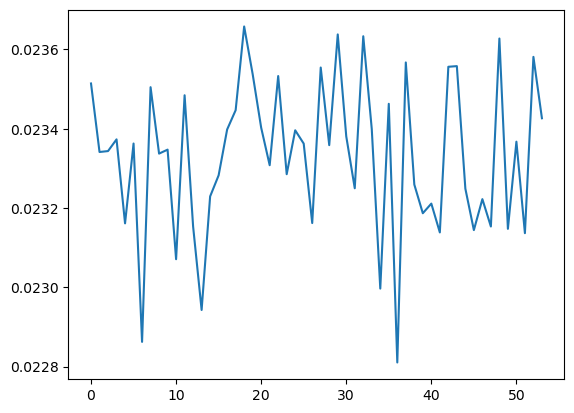

In [79]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

### Let's now evaluate the model using validation (test in this case) dataset. We will first evaluate using confusion matrix and then RMSE

### The model's output is currently continuous and we need to change it to discreet values. Below is a function that does that. The range to convert continuous output to a rating is based on the observations from previous training of the model

In [80]:
def convertOutputToRating(output):
    if (output > 4.0):
        return 5
    elif ( (output <= 4.0) and (output >= 3.5)):
        return 4
    elif (output < 3.5 and output >= 2.8):
        return 3
    elif (output < 2.8 and output > 2.5):
        return 2
    else: 
        return 1

In [90]:
model.eval()
y_pred_actual = []
y_pred_rating = []
y_actual = []    
    
with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        model_output = model(batched_data['users'].to(device), 
                       batched_data["books"].to(device))
        
        # Convert model ouput to numpy array
        numparray = model_output.squeeze().detach().cpu().numpy()
        
        #convert model output to ratings
        model_rating = [convertOutputToRating(x) for x in numparray]
        y_pred_actual.extend(numparray)
        y_pred_rating.extend(model_rating)
        y_actual.extend(batched_data['ratings'].detach().cpu().numpy().tolist())
        print (f"Model output {model_output} ratings from model {model_rating} actual ratings {batched_data['ratings']}" )



Model output tensor([[2.8639],
        [2.8639],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [3, 3, 4, 3] actual ratings tensor([3, 3, 4, 3])
Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 4, 4] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[3.5404],
        [2.5708],
        [4.3537],
        [3.5405]], device='cuda:0') ratings from model [4, 2, 5, 4] actual ratings tensor([4, 2, 5, 4])
Model output tensor([[4.3537],
        [3.5404],
        [3.5407],
        [4.3538]], device='cuda:0') ratings from model [5, 4, 4, 5] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[4.3537],
        [2.8646],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 3, 5] actual ratings tensor([5, 3, 3, 5])
Model output tensor([[2.8639],
        [4.3537],
        [4.3537],
        [2.5708]], device='cuda:0') ratings from model [3, 5, 5, 2] actual ratings tensor([3, 5, 5, 2])
Model output tensor([[4.3555],
        [3.5404],
        [4.3537],
        [3.5436]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[4.3537],
        [4.3531],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [4.3542],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.8639],
        [2.4307],
        [2.8757],
        [2.5759]], device='cuda:0') ratings from model [3, 1, 3, 2] actual ratings tensor([3, 1, 3, 2])
Model output tensor([[4.3537],
        [4.3537],
        [2.8641],
        [2.8640]], device='cuda:0') ratings from model [5, 5, 3, 3] actual ratings tensor([5, 5, 3, 3])
Model output tensor([[4.3533],
        [3.5404],
        [3.5404],
        [4.3598]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[3.5510],
        [2.8639],
        [4.3589],
        [3.5404]], device='cuda:0') ratings from model [4, 3, 5, 4] actual ratings tensor([4, 3, 5, 4])
Model output tensor([[4.3547],
        [3.5404],
        [4.3533],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual rat

Model output tensor([[3.5404],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 4, 5] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3579],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[3.5404],
        [4.3550],
        [4.3547],
        [2.8656]], device='cuda:0') ratings from model [4, 5, 5, 3] actual ratings tensor([4, 5, 5, 3])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [2.5708],
        [4.3549]], device='cuda:0') ratings from model [5, 5, 2, 5] actual rat

Model output tensor([[3.5404],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 5, 5] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5405],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3555],
        [3.5404],
        [2.5708],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 2, 5] actual ratings tensor([5, 4, 2, 5])
Model output tensor([[3.5404],
        [4.3537],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 3, 4] actual ratings tensor([4, 5, 3, 4])
Model output tensor([[4.3477],
        [3.5404],
        [2.5709],
        [2.8639]], device='cuda:0') ratings from model [5, 4, 2, 3] actual rat

Model output tensor([[4.3546],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3539]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3542],
        [3.5406],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 4, 4] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[2.8639],
        [2.8639],
        [3.5407],
        [3.5404]], device='cuda:0') ratings from model [3, 3, 4, 4] actual ratings tensor([3, 3, 4, 4])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [5, 4, 4, 3] actual ratings tensor([5, 4, 4, 3])
Model output tensor([[4.3547],
        [3.5510],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 3, 5] actual rat

Model output tensor([[4.3543],
        [3.5404],
        [3.5314],
        [4.3540]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[4.3561],
        [4.3540],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 3, 4] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.5708],
        [2.8639],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [2, 3, 5, 3] actual ratings tensor([2, 3, 5, 3])
Model output tensor([[4.3537],
        [4.3582],
        [4.3553],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5421],
        [2.8639],
        [2.4316],
        [4.3541]], device='cuda:0') ratings from model [4, 3, 1, 5] actual ratings tensor([4, 3, 1, 5])
Model output tensor([[2.4305],
        [2.8587],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [1, 3, 5, 4] actual rat

Model output tensor([[3.5431],
        [4.3549],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3538],
        [2.5708],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 2, 4] actual ratings tensor([4, 5, 2, 4])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.8689],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 4, 4] actual ratings tensor([3, 5, 4, 4])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 4, 5, 3] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[4.3538],
        [4.3537],
        [4.3537],
        [4.3539]], device='cuda:0') ratings from model [5, 5, 5, 5] actual rat

Model output tensor([[4.3537],
        [4.3540],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3538],
        [3.5406],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 4, 4] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.4307],
        [4.3531],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [1, 5, 5, 4] actual ratings tensor([1, 5, 5, 4])
Model output tensor([[4.3538],
        [4.3537],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 3, 4] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.8691],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 3, 5, 5] actual ratings tensor([3, 3, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3561],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual rat

Model output tensor([[3.5404],
        [4.3549],
        [3.5404],
        [3.5439]], device='cuda:0') ratings from model [4, 5, 4, 4] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[3.5341],
        [3.5404],
        [3.5403],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 4, 5] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3555],
        [2.4307],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 1, 5, 5] actual ratings tensor([5, 1, 5, 5])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [3.5405]], device='cuda:0') ratings from model [4, 4, 5, 4] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[4.3538],
        [4.3539],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 3, 4] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[4.3537],
        [4.3550],
        [2.5742],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 2, 5] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [3.5512]], device='cuda:0') ratings from model [4, 5, 4, 4] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[3.5404],
        [3.5404],
        [3.5404],
        [4.3551]], device='cuda:0') ratings from model [4, 4, 4, 5] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[3.5404],
        [3.5404],
        [4.3544],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 5, 5] actual rat

Model output tensor([[2.8641],
        [2.5708],
        [3.5409],
        [4.3539]], device='cuda:0') ratings from model [3, 2, 4, 5] actual ratings tensor([3, 2, 4, 5])
Model output tensor([[4.3537],
        [2.4307],
        [3.5433],
        [4.3537]], device='cuda:0') ratings from model [5, 1, 4, 5] actual ratings tensor([5, 1, 4, 5])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 4, 4] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[3.5404],
        [2.8639],
        [3.5404],
        [4.3614]], device='cuda:0') ratings from model [4, 3, 4, 5] actual ratings tensor([4, 3, 4, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5473],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual rat

Model output tensor([[2.8639],
        [2.5708],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 2, 5, 5] actual ratings tensor([3, 2, 5, 5])
Model output tensor([[2.8639],
        [4.3537],
        [4.3566],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.8639],
        [4.3538],
        [4.3537],
        [4.3544]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [4.3550]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[4.3538],
        [4.3537],
        [2.8639],
        [4.3550]], device='cuda:0') ratings from model [5, 5, 3, 5] actual rat

Model output tensor([[2.4307],
        [3.5422],
        [4.3537],
        [3.5412]], device='cuda:0') ratings from model [1, 4, 5, 4] actual ratings tensor([1, 4, 5, 4])
Model output tensor([[3.5399],
        [4.3537],
        [2.8639],
        [4.3547]], device='cuda:0') ratings from model [4, 5, 3, 5] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[3.5404],
        [3.5420],
        [4.3537],
        [2.5708]], device='cuda:0') ratings from model [4, 4, 5, 2] actual ratings tensor([4, 4, 5, 2])
Model output tensor([[4.3550],
        [4.3537],
        [4.3523],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3538],
        [4.3537],
        [4.3537],
        [2.5708]], device='cuda:0') ratings from model [5, 5, 5, 2] actual rat

Model output tensor([[3.5404],
        [3.5404],
        [2.8639],
        [2.8673]], device='cuda:0') ratings from model [4, 4, 3, 3] actual ratings tensor([4, 4, 3, 3])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3567],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [2.4307],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 1, 5, 4] actual ratings tensor([5, 1, 5, 4])
Model output tensor([[3.5404],
        [3.5404],
        [2.8639],
        [3.5416]], device='cuda:0') ratings from model [4, 4, 3, 4] actual ratings tensor([4, 4, 3, 4])
Model output tensor([[4.3537],
        [2.8642],
        [2.8639],
        [4.3581]], device='cuda:0') ratings from model [5, 3, 3, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [3.5415]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[3.5404],
        [2.8639],
        [4.3539],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 5, 5] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.8639],
        [3.5404],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [3, 4, 5, 3] actual ratings tensor([3, 4, 5, 3])
Model output tensor([[4.3540],
        [4.3537],
        [3.5404],
        [3.5406]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[4.3537],
        [3.5404],
        [4.3556],
        [4.3558]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[3.5401],
        [3.5450],
        [4.3561],
        [4.3543]], device='cuda:0') ratings from model [4, 4, 5, 5] actual rat

Model output tensor([[3.5412],
        [4.3581],
        [2.4307],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 1, 4] actual ratings tensor([4, 5, 1, 4])
Model output tensor([[4.3560],
        [3.5406],
        [4.3503],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3537],
        [3.5433],
        [2.8639],
        [2.5708]], device='cuda:0') ratings from model [5, 4, 3, 2] actual ratings tensor([5, 4, 3, 2])
Model output tensor([[3.5404],
        [4.3537],
        [3.5409],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 4, 4] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [2.8640]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[3.5404],
        [4.3545],
        [3.5404],
        [3.5428]], device='cuda:0') ratings from model [4, 5, 4, 4] actual rat

Model output tensor([[4.3546],
        [4.3537],
        [4.3538],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.8741],
        [4.3537],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 3, 5] actual ratings tensor([3, 5, 3, 5])
Model output tensor([[4.3537],
        [4.3565],
        [3.5404],
        [4.3543]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3538],
        [4.3537],
        [2.5708],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 2, 5] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.8639],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [3, 4, 4, 5] actual ratings tensor([3, 4, 4, 5])
Model output tensor([[4.3579],
        [2.5708],
        [4.3538],
        [4.3540]], device='cuda:0') ratings from model [5, 2, 5, 5] actual rat

Model output tensor([[4.3537],
        [4.3566],
        [2.5708],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 2, 3] actual ratings tensor([5, 5, 2, 3])
Model output tensor([[4.3537],
        [4.3567],
        [3.5421],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [2.5708]], device='cuda:0') ratings from model [5, 4, 5, 2] actual ratings tensor([5, 4, 5, 2])
Model output tensor([[4.3537],
        [2.8639],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 3, 4] actual ratings tensor([5, 3, 3, 4])
Model output tensor([[4.3543],
        [4.3537],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 3, 4] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[4.3537],
        [2.8644],
        [2.4316],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 1, 4] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3614],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[4.3537],
        [3.5404],
        [2.8639],
        [4.3543]], device='cuda:0') ratings from model [5, 4, 3, 5] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3532],
        [2.5701]], device='cuda:0') ratings from model [5, 5, 5, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[3.5438],
        [4.3547],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [4, 5, 5, 3] actual ratings tensor([4, 5, 5, 3])
Model output tensor([[4.3537],
        [4.3537],
        [3.5411],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual rat

Model output tensor([[4.3551],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.4307],
        [4.3537],
        [3.5425],
        [4.3537]], device='cuda:0') ratings from model [1, 5, 4, 5] actual ratings tensor([1, 5, 4, 5])
Model output tensor([[4.3545],
        [3.5404],
        [2.4307],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 1, 4] actual ratings tensor([5, 4, 1, 4])
Model output tensor([[4.3538],
        [4.3601],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 3, 4] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[4.3537],
        [2.8639],
        [2.8639],
        [4.3588]], device='cuda:0') ratings from model [5, 3, 3, 5] actual ratings tensor([5, 3, 3, 5])
Model output tensor([[3.5435],
        [2.8663],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 4, 5] actual rat

Model output tensor([[3.5404],
        [4.3555],
        [4.3541],
        [4.3538]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [2.5708],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 2, 4] actual ratings tensor([5, 5, 2, 4])
Model output tensor([[2.8639],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 5, 4] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.8639],
        [2.8639],
        [3.5404],
        [3.5405]], device='cuda:0') ratings from model [3, 3, 4, 4] actual ratings tensor([3, 3, 4, 4])
Model output tensor([[4.3537],
        [4.3543],
        [4.3537],
        [4.3535]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3539],
        [4.3537],
        [3.5404],
        [4.3591]], device='cuda:0') ratings from model [5, 5, 4, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [2.5708],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 2, 5] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[3.5404],
        [3.5441],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 4, 4] actual ratings tensor([4, 4, 4, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3559],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [2.8657]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[4.3537],
        [3.5404],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 3, 5] actual rat

Model output tensor([[3.5404],
        [3.5404],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 3, 5] actual ratings tensor([4, 4, 3, 5])
Model output tensor([[4.3538],
        [4.3537],
        [2.8640],
        [2.5708]], device='cuda:0') ratings from model [5, 5, 3, 2] actual ratings tensor([5, 5, 3, 2])
Model output tensor([[2.8639],
        [4.3537],
        [4.3539],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3566]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3542],
        [4.3541],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [2.8640]], device='cuda:0') ratings from model [5, 5, 4, 3] actual rat

Model output tensor([[4.3539],
        [3.5404],
        [3.5404],
        [4.3546]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.8642],
        [2.8639],
        [3.5404],
        [2.4307]], device='cuda:0') ratings from model [3, 3, 4, 1] actual ratings tensor([3, 3, 4, 1])
Model output tensor([[4.3537],
        [3.5404],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 3, 4] actual ratings tensor([5, 4, 3, 4])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [4.3565]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[4.3537],
        [2.8639],
        [2.5708],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 2, 5] actual ratings tensor([5, 3, 2, 5])
Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 4, 4] actual rat

Model output tensor([[3.5404],
        [3.5422],
        [4.3537],
        [2.4309]], device='cuda:0') ratings from model [4, 4, 5, 1] actual ratings tensor([4, 4, 5, 1])
Model output tensor([[4.3537],
        [3.5404],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 3, 5] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[4.3537],
        [2.5708],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 2, 5, 5] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [2.8639],
        [3.5401]], device='cuda:0') ratings from model [4, 5, 3, 4] actual ratings tensor([4, 5, 3, 4])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [2.4311]], device='cuda:0') ratings from model [5, 4, 5, 1] actual ratings tensor([5, 4, 5, 1])
Model output tensor([[4.3537],
        [4.3537],
        [4.3543],
        [4.3549]], device='cuda:0') ratings from model [5, 5, 5, 5] actual rat

Model output tensor([[3.5405],
        [4.3537],
        [4.3592],
        [3.5405]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[4.3537],
        [2.4307],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 1, 5, 5] actual ratings tensor([5, 1, 5, 5])
Model output tensor([[4.3537],
        [4.3542],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3614],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [2.8639],
        [2.8639]], device='cuda:0') ratings from model [4, 5, 3, 3] actual ratings tensor([4, 5, 3, 3])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [3.5427]], device='cuda:0') ratings from model [5, 4, 5, 4] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [4.3533],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3538],
        [4.3539],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.5704],
        [3.5405],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [2, 4, 5, 4] actual ratings tensor([2, 4, 5, 4])
Model output tensor([[4.3537],
        [2.8639],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 3, 5] actual ratings tensor([5, 3, 3, 5])
Model output tensor([[4.3537],
        [3.5432],
        [4.3554],
        [4.3546]], device='cuda:0') ratings from model [5, 4, 5, 5] actual rat

Model output tensor([[4.3537],
        [4.3614],
        [4.3560],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3553],
        [3.5404],
        [4.3557],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[4.3538],
        [3.5404],
        [2.5715],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 2, 4] actual ratings tensor([5, 4, 2, 4])
Model output tensor([[4.3538],
        [3.5405],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3537],
        [4.3503],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [2.8639],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 4, 4] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [2.5708],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 2, 5] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[3.5404],
        [2.8640],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 3, 5] actual ratings tensor([4, 3, 3, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.8644],
        [4.3537],
        [2.8639],
        [4.3538]], device='cuda:0') ratings from model [3, 5, 3, 5] actual ratings tensor([3, 5, 3, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.4307],
        [3.5404],
        [4.3537],
        [2.4307]], device='cuda:0') ratings from model [1, 4, 5, 1] actual rat

Model output tensor([[3.5432],
        [2.8639],
        [2.8650],
        [2.4307]], device='cuda:0') ratings from model [4, 3, 3, 1] actual ratings tensor([4, 3, 3, 1])
Model output tensor([[4.3537],
        [2.8639],
        [4.3545],
        [2.8639]], device='cuda:0') ratings from model [5, 3, 5, 3] actual ratings tensor([5, 3, 5, 3])
Model output tensor([[2.5745],
        [4.3546],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [2, 5, 5, 4] actual ratings tensor([2, 5, 5, 4])
Model output tensor([[3.5404],
        [4.3540],
        [4.3538],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[4.3537],
        [3.5404],
        [2.8644],
        [3.5400]], device='cuda:0') ratings from model [5, 4, 3, 4] actual ratings tensor([5, 4, 3, 4])
Model output tensor([[4.3537],
        [4.3592],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual rat

Model output tensor([[3.5405],
        [3.5510],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [2.4307],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 1, 5] actual ratings tensor([5, 5, 1, 5])
Model output tensor([[3.5404],
        [2.8639],
        [3.5404],
        [3.5407]], device='cuda:0') ratings from model [4, 3, 4, 4] actual ratings tensor([4, 3, 4, 4])
Model output tensor([[4.3559],
        [2.8639],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 3, 5, 3] actual ratings tensor([5, 3, 5, 3])
Model output tensor([[4.3537],
        [4.3538],
        [4.3538],
        [2.8677]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.5704],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [2, 4, 5, 5] actual rat

Model output tensor([[4.3537],
        [2.8639],
        [4.3539],
        [2.8639]], device='cuda:0') ratings from model [5, 3, 5, 3] actual ratings tensor([5, 3, 5, 3])
Model output tensor([[3.5343],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3538],
        [3.5400],
        [4.3540],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.8639],
        [4.3537],
        [4.3582],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[4.3533],
        [2.5708],
        [4.3538],
        [3.5416]], device='cuda:0') ratings from model [5, 2, 5, 4] actual ratings tensor([5, 2, 5, 4])
Model output tensor([[3.5404],
        [4.3558],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual rat

Model output tensor([[4.3567],
        [4.3541],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3542],
        [4.3559],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5410],
        [4.3543]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.5708],
        [4.3537],
        [2.8639],
        [4.3567]], device='cuda:0') ratings from model [2, 5, 3, 5] actual rat

Model output tensor([[3.5405],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 4, 4] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[4.3537],
        [4.3538],
        [4.3537],
        [2.8650]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[3.5412],
        [4.3538],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3566],
        [2.8639],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 3, 5] actual ratings tensor([5, 3, 3, 5])
Model output tensor([[4.3518],
        [3.5404],
        [3.5386],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 4, 4] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.8639],
        [2.5708],
        [4.3537],
        [2.4241]], device='cuda:0') ratings from model [3, 2, 5, 1] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [3.5406]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[4.3537],
        [4.3540],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.8639],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 4, 5] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [2.5752]], device='cuda:0') ratings from model [5, 5, 4, 2] actual ratings tensor([5, 5, 4, 2])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [2.5740]], device='cuda:0') ratings from model [5, 4, 5, 2] actual ratings tensor([5, 4, 5, 2])
Model output tensor([[4.3555],
        [3.5410],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 4, 5, 3] actual rat

Model output tensor([[4.3553],
        [3.5404],
        [4.3537],
        [2.8660]], device='cuda:0') ratings from model [5, 4, 5, 3] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[4.3539],
        [2.5708],
        [4.3537],
        [4.3549]], device='cuda:0') ratings from model [5, 2, 5, 5] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[4.3567],
        [2.8648],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 3, 4] actual ratings tensor([5, 3, 3, 4])
Model output tensor([[3.5405],
        [4.3538],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5408],
        [2.4423]], device='cuda:0') ratings from model [5, 5, 4, 1] actual ratings tensor([5, 5, 4, 1])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual rat

Model output tensor([[3.5404],
        [3.5404],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [4, 4, 4, 3] actual ratings tensor([4, 4, 4, 3])
Model output tensor([[3.5404],
        [4.3553],
        [2.8717],
        [4.3555]], device='cuda:0') ratings from model [4, 5, 3, 5] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[4.3546],
        [3.5404],
        [2.8660],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 3, 4] actual ratings tensor([5, 4, 3, 4])
Model output tensor([[3.5405],
        [2.8639],
        [4.3537],
        [4.3574]], device='cuda:0') ratings from model [4, 3, 5, 5] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[3.5421],
        [4.3537],
        [3.5404],
        [2.4297]], device='cuda:0') ratings from model [4, 5, 4, 1] actual ratings tensor([4, 5, 4, 1])
Model output tensor([[4.3537],
        [4.3604],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual rat

Model output tensor([[3.5421],
        [2.8639],
        [4.3517],
        [4.3586]], device='cuda:0') ratings from model [4, 3, 5, 5] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3574],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.8639],
        [4.3539],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.4307],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [1, 4, 5, 5] actual ratings tensor([1, 4, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3541],
        [3.5412]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3589],
        [3.5404],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual rat

Model output tensor([[3.5404],
        [4.3537],
        [2.5708],
        [4.3538]], device='cuda:0') ratings from model [4, 5, 2, 5] actual ratings tensor([4, 5, 2, 5])
Model output tensor([[3.5404],
        [4.3541],
        [4.3537],
        [2.5720]], device='cuda:0') ratings from model [4, 5, 5, 2] actual ratings tensor([4, 5, 5, 2])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3540]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3537],
        [4.3544],
        [4.3537],
        [4.3546]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3572],
        [4.3537],
        [3.5404],
        [4.3559]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [3.5416]], device='cuda:0') ratings from model [5, 5, 4, 4] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [2.5731]], device='cuda:0') ratings from model [5, 5, 5, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[4.3538],
        [2.4307],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 1, 4, 5] actual ratings tensor([5, 1, 4, 5])
Model output tensor([[2.8639],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 3, 5, 5] actual ratings tensor([3, 3, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3539],
        [2.8639]], device='cuda:0') ratings from model [4, 5, 5, 3] actual ratings tensor([4, 5, 5, 3])
Model output tensor([[3.5404],
        [4.3537],
        [4.3549],
        [2.5750]], device='cuda:0') ratings from model [4, 5, 5, 2] actual ratings tensor([4, 5, 5, 2])
Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual rat

Model output tensor([[4.3538],
        [2.8642],
        [2.5708],
        [2.8639]], device='cuda:0') ratings from model [5, 3, 2, 3] actual ratings tensor([5, 3, 2, 3])
Model output tensor([[2.4307],
        [3.5404],
        [3.5404],
        [4.3538]], device='cuda:0') ratings from model [1, 4, 4, 5] actual ratings tensor([1, 4, 4, 5])
Model output tensor([[4.3537],
        [4.3572],
        [3.5401],
        [2.8651]], device='cuda:0') ratings from model [5, 5, 4, 3] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[3.5404],
        [2.5713],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 2, 4, 5] actual ratings tensor([4, 2, 4, 5])
Model output tensor([[4.3538],
        [3.5404],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 3, 4] actual ratings tensor([5, 4, 3, 4])
Model output tensor([[4.3547],
        [4.3536],
        [4.3537],
        [4.3517]], device='cuda:0') ratings from model [5, 5, 5, 5] actual rat

Model output tensor([[2.8657],
        [3.5404],
        [2.5708],
        [2.8695]], device='cuda:0') ratings from model [3, 4, 2, 3] actual ratings tensor([3, 4, 2, 3])
Model output tensor([[4.3537],
        [3.5438],
        [4.3545],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.8639],
        [4.3558],
        [4.3557],
        [2.8639]], device='cuda:0') ratings from model [3, 5, 5, 3] actual ratings tensor([3, 5, 5, 3])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [5, 4, 4, 3] actual ratings tensor([5, 4, 4, 3])
Model output tensor([[4.3537],
        [2.8641],
        [4.3537],
        [4.3542]], device='cuda:0') ratings from model [5, 3, 5, 5] actual rat

Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.8505],
        [4.3537],
        [4.3542],
        [4.3554]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[3.5431],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [4, 5, 4, 3] actual ratings tensor([4, 5, 4, 3])
Model output tensor([[4.3537],
        [3.5404],
        [4.3538],
        [2.8666]], device='cuda:0') ratings from model [5, 4, 5, 3] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [4.3543]], device='cuda:0') ratings from model [4, 4, 5, 5] actual rat

Model output tensor([[3.5404],
        [4.3547],
        [2.4307],
        [2.8639]], device='cuda:0') ratings from model [4, 5, 1, 3] actual ratings tensor([4, 5, 1, 3])
Model output tensor([[3.5343],
        [4.3563],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [2.5708],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 2, 5] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[3.5401],
        [3.5404],
        [3.5404],
        [2.5708]], device='cuda:0') ratings from model [4, 4, 4, 2] actual ratings tensor([4, 4, 4, 2])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3541],
        [4.3537],
        [4.3614],
        [4.3614]], device='cuda:0') ratings from model [5, 5, 5, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [3.5432],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 4, 3] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3545],
        [4.3546],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[4.3564],
        [3.5404],
        [4.3538],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.8639],
        [3.5404],
        [4.3537],
        [4.3543]], device='cuda:0') ratings from model [3, 4, 5, 5] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[4.3540],
        [2.8639],
        [4.3538],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 5, 5] actual rat

Model output tensor([[3.5404],
        [2.5708],
        [4.3537],
        [3.5412]], device='cuda:0') ratings from model [4, 2, 5, 4] actual ratings tensor([4, 2, 5, 4])
Model output tensor([[4.3579],
        [4.3537],
        [4.3537],
        [3.5401]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[3.5413],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.4317],
        [3.5510],
        [2.4307],
        [4.3555]], device='cuda:0') ratings from model [1, 4, 1, 5] actual ratings tensor([1, 4, 1, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[3.5404],
        [2.5708],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 2, 5, 5] actual rat

Model output tensor([[4.3537],
        [2.5708],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 2, 4, 5] actual ratings tensor([5, 2, 4, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3579]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3537],
        [2.4275],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 1, 5, 5] actual ratings tensor([5, 1, 5, 5])
Model output tensor([[4.3537],
        [4.3517],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3539],
        [3.5404],
        [4.3537],
        [2.5708]], device='cuda:0') ratings from model [5, 4, 5, 2] actual ratings tensor([5, 4, 5, 2])
Model output tensor([[2.4307],
        [2.5708],
        [4.3537],
        [4.3543]], device='cuda:0') ratings from model [1, 2, 5, 5] actual rat

Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [3.5452]], device='cuda:0') ratings from model [4, 5, 4, 4] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[3.5404],
        [4.3537],
        [4.3547],
        [4.3558]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.5708],
        [4.3555],
        [2.8646],
        [3.5404]], device='cuda:0') ratings from model [2, 5, 3, 4] actual ratings tensor([2, 5, 3, 4])
Model output tensor([[4.3539],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [3.5404],
        [3.5386],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[3.5404],
        [2.5708],
        [4.3546],
        [3.5431]], device='cuda:0') ratings from model [4, 2, 5, 4] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [4.3558],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3566],
        [4.3537],
        [4.3537],
        [4.3550]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3543],
        [2.8639],
        [3.5409],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 4, 4] actual ratings tensor([5, 3, 4, 4])
Model output tensor([[3.5404],
        [2.8683],
        [2.8644],
        [3.5401]], device='cuda:0') ratings from model [4, 3, 3, 4] actual ratings tensor([4, 3, 3, 4])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3543]], device='cuda:0') ratings from model [5, 4, 5, 5] actual rat

Model output tensor([[4.3589],
        [4.3614],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [2.4307]], device='cuda:0') ratings from model [5, 5, 4, 1] actual ratings tensor([5, 5, 4, 1])
Model output tensor([[3.5408],
        [4.3537],
        [2.8639],
        [4.3560]], device='cuda:0') ratings from model [4, 5, 3, 5] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[3.5404],
        [4.3537],
        [2.5708],
        [4.3539]], device='cuda:0') ratings from model [4, 5, 2, 5] actual ratings tensor([4, 5, 2, 5])
Model output tensor([[4.3537],
        [3.5404],
        [2.8639],
        [3.5421]], device='cuda:0') ratings from model [5, 4, 3, 4] actual ratings tensor([5, 4, 3, 4])
Model output tensor([[3.5404],
        [3.5404],
        [3.5418],
        [4.3542]], device='cuda:0') ratings from model [4, 4, 4, 5] actual rat

Model output tensor([[3.5404],
        [4.3537],
        [2.8639],
        [3.5430]], device='cuda:0') ratings from model [4, 5, 3, 4] actual ratings tensor([4, 5, 3, 4])
Model output tensor([[3.5410],
        [2.8644],
        [4.3531],
        [2.5708]], device='cuda:0') ratings from model [4, 3, 5, 2] actual ratings tensor([4, 3, 5, 2])
Model output tensor([[4.3538],
        [2.8653],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.8671],
        [3.5404],
        [2.5714],
        [4.3537]], device='cuda:0') ratings from model [3, 4, 2, 5] actual ratings tensor([3, 4, 2, 5])
Model output tensor([[4.3614],
        [4.3537],
        [3.5404],
        [2.5708]], device='cuda:0') ratings from model [5, 5, 4, 2] actual ratings tensor([5, 5, 4, 2])
Model output tensor([[2.8639],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 5, 5] actual rat

Model output tensor([[4.3559],
        [3.5406],
        [3.5416],
        [4.3538]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.5708],
        [4.3538],
        [4.3537],
        [4.3558]], device='cuda:0') ratings from model [2, 5, 5, 5] actual ratings tensor([2, 5, 5, 5])
Model output tensor([[4.3517],
        [2.4311],
        [4.3537],
        [3.5408]], device='cuda:0') ratings from model [5, 1, 5, 4] actual ratings tensor([5, 1, 5, 4])
Model output tensor([[4.3537],
        [3.5404],
        [2.4310],
        [2.8639]], device='cuda:0') ratings from model [5, 4, 1, 3] actual ratings tensor([5, 4, 1, 3])
Model output tensor([[3.5404],
        [4.3551],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 3, 5] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[3.5404],
        [4.3537],
        [2.8650],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 3, 5] actual rat

Model output tensor([[2.5708],
        [4.3557],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [2, 5, 4, 5] actual ratings tensor([2, 5, 4, 5])
Model output tensor([[4.3550],
        [3.5404],
        [4.3537],
        [2.8640]], device='cuda:0') ratings from model [5, 4, 5, 3] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[2.4307],
        [3.5415],
        [2.8639],
        [2.5708]], device='cuda:0') ratings from model [1, 4, 3, 2] actual ratings tensor([1, 4, 3, 2])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5404],
        [3.5404],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [4, 4, 4, 3] actual ratings tensor([4, 4, 4, 3])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3546]], device='cuda:0') ratings from model [5, 5, 5, 5] actual rat

Model output tensor([[2.4307],
        [2.5708],
        [4.3537],
        [4.3503]], device='cuda:0') ratings from model [1, 2, 5, 5] actual ratings tensor([1, 2, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [4.3538]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[4.3550],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.8639],
        [2.4307],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [3, 1, 5, 4] actual ratings tensor([3, 1, 5, 4])
Model output tensor([[3.5419],
        [2.5708],
        [2.8640],
        [3.5404]], device='cuda:0') ratings from model [4, 2, 3, 4] actual ratings tensor([4, 2, 3, 4])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual rat

Model output tensor([[2.8639],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [3, 4, 4, 5] actual ratings tensor([3, 4, 4, 5])
Model output tensor([[3.5404],
        [2.4290],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [4, 1, 4, 4] actual ratings tensor([4, 1, 4, 4])
Model output tensor([[4.3537],
        [4.3537],
        [2.5708],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 2, 5] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[2.4330],
        [4.3537],
        [3.5404],
        [4.3582]], device='cuda:0') ratings from model [1, 5, 4, 5] actual ratings tensor([1, 5, 4, 5])
Model output tensor([[2.4307],
        [4.3537],
        [4.3537],
        [3.5435]], device='cuda:0') ratings from model [1, 5, 5, 4] actual ratings tensor([1, 5, 5, 4])
Model output tensor([[3.5404],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 5, 5] actual rat

Model output tensor([[4.3547],
        [3.5404],
        [3.5444],
        [2.8639]], device='cuda:0') ratings from model [5, 4, 4, 3] actual ratings tensor([5, 4, 4, 3])
Model output tensor([[4.3537],
        [4.3537],
        [4.3565],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[3.5432],
        [3.5452],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3541],
        [4.3540]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3541],
        [2.5711],
        [4.3564],
        [3.5404]], device='cuda:0') ratings from model [5, 2, 5, 4] actual ratings tensor([5, 2, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual rat

Model output tensor([[4.3537],
        [4.3562],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[3.5404],
        [4.3537],
        [2.5708],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 2, 4] actual ratings tensor([4, 5, 2, 4])
Model output tensor([[4.3537],
        [4.3537],
        [2.8640],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 3, 5] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.8639],
        [4.3537],
        [3.5404],
        [2.5708]], device='cuda:0') ratings from model [3, 5, 4, 2] actual ratings tensor([3, 5, 4, 2])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3589],
        [4.3448],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual rat

Model output tensor([[4.3538],
        [3.5406],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.8639],
        [2.8639],
        [4.3582],
        [3.5414]], device='cuda:0') ratings from model [3, 3, 5, 4] actual ratings tensor([3, 3, 5, 4])
Model output tensor([[2.8639],
        [3.5404],
        [4.3538],
        [3.5404]], device='cuda:0') ratings from model [3, 4, 5, 4] actual ratings tensor([3, 4, 5, 4])
Model output tensor([[2.4346],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [1, 5, 4, 4] actual ratings tensor([1, 5, 4, 4])
Model output tensor([[2.4325],
        [2.8639],
        [2.8639],
        [4.3555]], device='cuda:0') ratings from model [1, 3, 3, 5] actual ratings tensor([1, 3, 3, 5])
Model output tensor([[2.5708],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [2, 5, 5, 5] actual rat

Model output tensor([[3.5404],
        [2.8639],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 4, 5] actual ratings tensor([4, 3, 4, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3551],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [2.5708]], device='cuda:0') ratings from model [5, 4, 4, 2] actual ratings tensor([5, 4, 4, 2])
Model output tensor([[2.4310],
        [3.5404],
        [3.5404],
        [4.3555]], device='cuda:0') ratings from model [1, 4, 4, 5] actual ratings tensor([1, 4, 4, 5])
Model output tensor([[3.5440],
        [4.3542],
        [4.3537],
        [3.5406]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[3.5404],
        [2.5708],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 2, 4, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.5823],
        [3.5404],
        [2.8675],
        [2.5720]], device='cuda:0') ratings from model [2, 4, 3, 2] actual ratings tensor([2, 4, 3, 2])
Model output tensor([[4.3588],
        [3.5434],
        [3.5411],
        [2.5708]], device='cuda:0') ratings from model [5, 4, 4, 2] actual ratings tensor([5, 4, 4, 2])
Model output tensor([[4.3537],
        [4.3537],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 3, 4] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.8639],
        [2.5723],
        [4.3537],
        [4.3561]], device='cuda:0') ratings from model [3, 2, 5, 5] actual ratings tensor([3, 2, 5, 5])
Model output tensor([[2.8639],
        [2.8639],
        [2.8640],
        [4.3537]], device='cuda:0') ratings from model [3, 3, 3, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [2.4306],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 1, 5] actual ratings tensor([5, 5, 1, 5])
Model output tensor([[4.3536],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[3.5404],
        [4.3537],
        [2.5708],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 2, 5] actual ratings tensor([4, 5, 2, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3555],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3538],
        [4.3555],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.8639],
        [2.8674],
        [4.3537],
        [2.5716]], device='cuda:0') ratings from model [3, 3, 5, 2] actual rat

Model output tensor([[3.5420],
        [3.5404],
        [2.8639],
        [2.8604]], device='cuda:0') ratings from model [4, 4, 3, 3] actual ratings tensor([4, 4, 3, 3])
Model output tensor([[4.3537],
        [2.5717],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 2, 4, 5] actual ratings tensor([5, 2, 4, 5])
Model output tensor([[3.5404],
        [4.3538],
        [4.3561],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5420],
        [4.3579],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[3.5404],
        [3.5404],
        [4.3540],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 5, 5] actual rat

Model output tensor([[2.8639],
        [4.3537],
        [4.3539],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 5, 4] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[4.3495],
        [2.5708],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 2, 3, 5] actual ratings tensor([5, 2, 3, 5])
Model output tensor([[4.3537],
        [4.3538],
        [2.8639],
        [2.5711]], device='cuda:0') ratings from model [5, 5, 3, 2] actual ratings tensor([5, 5, 3, 2])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [3.5411],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual rat

Model output tensor([[4.3537],
        [3.5443],
        [4.3570],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[3.5404],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 5, 5] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.4307],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [1, 5, 5, 5] actual ratings tensor([1, 5, 5, 5])
Model output tensor([[2.5708],
        [4.3537],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [2, 5, 5, 5] actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.8639],
        [4.3572],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 5, 4] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[4.3544],
        [2.8639],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 4, 4] actual rat

Model output tensor([[3.5404],
        [4.3537],
        [2.5708],
        [2.8639]], device='cuda:0') ratings from model [4, 5, 2, 3] actual ratings tensor([4, 5, 2, 3])
Model output tensor([[3.5404],
        [2.8639],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [4, 3, 4, 3] actual ratings tensor([4, 3, 4, 3])
Model output tensor([[2.5708],
        [3.5404],
        [3.5404],
        [2.8698]], device='cuda:0') ratings from model [2, 4, 4, 3] actual ratings tensor([2, 4, 4, 3])
Model output tensor([[3.5404],
        [4.3541],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 3, 5] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[3.5404],
        [2.5708],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [4, 2, 5, 5] actual ratings tensor([4, 2, 5, 5])
Model output tensor([[3.5404],
        [2.4307],
        [4.3555],
        [4.3537]], device='cuda:0') ratings from model [4, 1, 5, 5] actual rat

Model output tensor([[2.8671],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 3, 5, 5] actual ratings tensor([3, 3, 5, 5])
Model output tensor([[2.5708],
        [4.3537],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [2, 5, 5, 3] actual ratings tensor([2, 5, 5, 3])
Model output tensor([[4.3537],
        [2.5708],
        [3.5404],
        [4.3539]], device='cuda:0') ratings from model [5, 2, 4, 5] actual ratings tensor([5, 2, 4, 5])
Model output tensor([[2.4311],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [1, 4, 5, 5] actual ratings tensor([1, 4, 5, 5])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 5, 4] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [5, 4, 5, 5] actual rat

Model output tensor([[2.8598],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 5, 4] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [2.4351]], device='cuda:0') ratings from model [5, 4, 4, 1] actual ratings tensor([5, 4, 4, 1])
Model output tensor([[4.3537],
        [2.5708],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 2, 5, 5] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.8676],
        [3.5404],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [3, 4, 5, 4] actual ratings tensor([3, 4, 5, 4])
Model output tensor([[4.3537],
        [4.3550],
        [2.4307],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 1, 5] actual ratings tensor([5, 5, 1, 5])
Model output tensor([[4.3567],
        [4.3537],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 4, 3] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[4.3537],
        [4.3537],
        [3.5487],
        [3.5430]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[3.5404],
        [4.3537],
        [4.3473],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3588],
        [2.8639],
        [2.4307]], device='cuda:0') ratings from model [5, 5, 3, 1] actual ratings tensor([5, 5, 3, 1])
Model output tensor([[3.5404],
        [2.8639],
        [4.3537],
        [4.3546]], device='cuda:0') ratings from model [4, 3, 5, 5] actual rat

Model output tensor([[2.5708],
        [4.3537],
        [4.3537],
        [4.3551]], device='cuda:0') ratings from model [2, 5, 5, 5] actual ratings tensor([2, 5, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3541],
        [4.3561]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.5708],
        [3.5404],
        [2.8639],
        [2.8639]], device='cuda:0') ratings from model [2, 4, 3, 3] actual ratings tensor([2, 4, 3, 3])
Model output tensor([[2.8639],
        [4.3539],
        [4.3543],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[3.5404],
        [2.4307],
        [4.3565],
        [4.3539]], device='cuda:0') ratings from model [4, 1, 5, 5] actual ratings tensor([4, 1, 5, 5])
Model output tensor([[2.8639],
        [4.3525],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 3, 5] actual rat

Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [4.3544]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 4, 4] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[3.5404],
        [2.8639],
        [3.5404],
        [4.3553]], device='cuda:0') ratings from model [4, 3, 4, 5] actual ratings tensor([4, 3, 4, 5])
Model output tensor([[4.3546],
        [4.3541],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3544],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[3.5404],
        [4.3557],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [4, 5, 5, 3] actual rat

Model output tensor([[3.5404],
        [4.3547],
        [4.3537],
        [3.5375]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[3.5404],
        [4.3537],
        [2.8639],
        [4.3549]], device='cuda:0') ratings from model [4, 5, 3, 5] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3538],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3545],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [3.5452],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual rat

Model output tensor([[4.3537],
        [2.8639],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [3.5457],
        [4.3562]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[4.3537],
        [3.5404],
        [2.4307],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 1, 5] actual ratings tensor([5, 4, 1, 5])
Model output tensor([[3.5404],
        [4.3556],
        [3.5412],
        [2.5742]], device='cuda:0') ratings from model [4, 5, 4, 2] actual ratings tensor([4, 5, 4, 2])
Model output tensor([[3.5413],
        [2.8705],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 4, 5] actual ratings tensor([4, 3, 4, 5])
Model output tensor([[4.3525],
        [2.5708],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 2, 5, 5] actual rat

Model output tensor([[3.5404],
        [4.3538],
        [4.3554],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3538],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3537],
        [3.5413],
        [3.5404],
        [4.3538]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[4.3537],
        [2.8639],
        [3.5404],
        [2.5708]], device='cuda:0') ratings from model [5, 3, 4, 2] actual ratings tensor([5, 3, 4, 2])
Model output tensor([[3.5404],
        [4.3536],
        [2.4307],
        [3.5406]], device='cuda:0') ratings from model [4, 5, 1, 4] actual ratings tensor([4, 5, 1, 4])
Model output tensor([[2.8639],
        [3.5395],
        [4.3537],
        [3.5422]], device='cuda:0') ratings from model [3, 4, 5, 4] actual rat

Model output tensor([[4.3539],
        [4.3536],
        [2.8639],
        [2.8673]], device='cuda:0') ratings from model [5, 5, 3, 3] actual ratings tensor([5, 5, 3, 3])
Model output tensor([[3.5404],
        [3.5405],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[3.5422],
        [2.8668],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [4, 3, 4, 4] actual ratings tensor([4, 3, 4, 4])
Model output tensor([[4.3538],
        [4.3573],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.4307],
        [3.5431],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [1, 4, 5, 4] actual ratings tensor([1, 4, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3588],
        [2.4307]], device='cuda:0') ratings from model [5, 5, 5, 1] actual rat

Model output tensor([[4.3548],
        [4.3544],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3542]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [3.5406],
        [3.5404],
        [4.3560]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5420],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.8639],
        [4.3561],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 5, 5] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [2.5573],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 2, 5] actual ratings tensor([5, 4, 2, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5428],
        [4.3537],
        [4.3538],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5417],
        [2.5700],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 2, 5, 5] actual ratings tensor([4, 2, 5, 5])
Model output tensor([[2.8638],
        [2.5708],
        [2.8639],
        [4.3543]], device='cuda:0') ratings from model [3, 2, 3, 5] actual ratings tensor([3, 2, 3, 5])
Model output tensor([[4.3537],
        [3.5404],
        [3.5418],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 4, 4] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[3.5435],
        [4.3558],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[4.3545],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.8639],
        [3.5404],
        [3.5404],
        [3.5415]], device='cuda:0') ratings from model [3, 4, 4, 4] actual ratings tensor([3, 4, 4, 4])
Model output tensor([[4.3537],
        [4.3536],
        [2.8648],
        [2.5708]], device='cuda:0') ratings from model [5, 5, 3, 2] actual ratings tensor([5, 5, 3, 2])
Model output tensor([[4.3537],
        [4.3573],
        [3.5404],
        [2.4307]], device='cuda:0') ratings from model [5, 5, 4, 1] actual rat

Model output tensor([[4.3598],
        [4.3537],
        [4.3614],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [2.8642],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 3, 5] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[4.3538],
        [4.3537],
        [2.8639],
        [3.5441]], device='cuda:0') ratings from model [5, 5, 3, 4] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[4.3537],
        [4.3542],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[3.5404],
        [3.5407],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 5, 4] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[4.3540],
        [4.3537],
        [3.5404],
        [2.5708]], device='cuda:0') ratings from model [5, 5, 4, 2] actual rat

Model output tensor([[3.5404],
        [4.3557],
        [4.3537],
        [2.4307]], device='cuda:0') ratings from model [4, 5, 5, 1] actual ratings tensor([4, 5, 5, 1])
Model output tensor([[2.8639],
        [2.8639],
        [2.8639],
        [4.3538]], device='cuda:0') ratings from model [3, 3, 3, 5] actual ratings tensor([3, 3, 3, 5])
Model output tensor([[3.5404],
        [3.5406],
        [3.5406],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 4, 5] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[3.5404],
        [2.5708],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 2, 4, 5] actual ratings tensor([4, 2, 4, 5])
Model output tensor([[3.5404],
        [2.8639],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 4, 5] actual ratings tensor([4, 3, 4, 5])
Model output tensor([[4.3537],
        [2.8639],
        [4.3537],
        [4.3540]], device='cuda:0') ratings from model [5, 3, 5, 5] actual rat

Model output tensor([[4.3539],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5403],
        [2.5708],
        [2.8641],
        [4.3540]], device='cuda:0') ratings from model [4, 2, 3, 5] actual ratings tensor([4, 2, 3, 5])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [4.3561]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[4.3539],
        [4.3541],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[3.5404],
        [4.3537],
        [4.3556],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual rat

Model output tensor([[2.8639],
        [4.3550],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 4, 4] actual ratings tensor([3, 5, 4, 4])
Model output tensor([[4.3537],
        [2.4307],
        [3.5430],
        [2.8548]], device='cuda:0') ratings from model [5, 1, 4, 3] actual ratings tensor([5, 1, 4, 3])
Model output tensor([[3.5401],
        [4.3537],
        [4.3543],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [3.5416]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3538],
        [4.3537],
        [4.3539],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [2.8639],
        [4.3537],
        [4.3542]], device='cuda:0') ratings from model [5, 3, 5, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.5708],
        [4.3537],
        [3.5404],
        [4.3561]], device='cuda:0') ratings from model [2, 5, 4, 5] actual ratings tensor([2, 5, 4, 5])
Model output tensor([[3.5404],
        [3.5404],
        [3.5453],
        [4.3543]], device='cuda:0') ratings from model [4, 4, 4, 5] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[4.3567],
        [4.3537],
        [3.5464],
        [4.3541]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5452],
        [3.5400]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[3.5422],
        [4.3537],
        [4.3588],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual rat

Model output tensor([[4.3565],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[3.5404],
        [2.5742],
        [4.3567],
        [4.3539]], device='cuda:0') ratings from model [4, 2, 5, 5] actual ratings tensor([4, 2, 5, 5])
Model output tensor([[3.5404],
        [2.8722],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 4, 5] actual ratings tensor([4, 3, 4, 5])
Model output tensor([[4.3549],
        [2.8644],
        [4.3538],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 5, 4] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [2.5758],
        [2.4335]], device='cuda:0') ratings from model [5, 5, 2, 1] actual ratings tensor([5, 5, 2, 1])
Model output tensor([[4.3537],
        [3.5404],
        [4.3538],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual rat

Model output tensor([[4.3553],
        [3.5404],
        [4.3532],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.8677],
        [2.8639],
        [4.3537],
        [2.4341]], device='cuda:0') ratings from model [3, 3, 5, 1] actual ratings tensor([3, 3, 5, 1])
Model output tensor([[3.5433],
        [4.3537],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [4, 5, 4, 3] actual ratings tensor([4, 5, 4, 3])
Model output tensor([[3.5404],
        [4.3544],
        [2.4307],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 1, 5] actual ratings tensor([4, 5, 1, 5])
Model output tensor([[4.3542],
        [4.3540],
        [3.5375],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.8639],
        [3.5404],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [3, 4, 5, 4] actual rat

Model output tensor([[4.3538],
        [4.3537],
        [2.8755],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 3, 5] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[4.3592],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[3.5404],
        [4.3537],
        [2.4307],
        [2.8640]], device='cuda:0') ratings from model [4, 5, 1, 3] actual ratings tensor([4, 5, 1, 3])
Model output tensor([[2.5709],
        [4.3558],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [2, 5, 4, 5] actual ratings tensor([2, 5, 4, 5])
Model output tensor([[4.3542],
        [3.5410],
        [4.3561],
        [4.3540]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3537],
        [4.3540],
        [4.3562],
        [3.5401]], device='cuda:0') ratings from model [5, 5, 5, 4] actual rat

Model output tensor([[4.3539],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[3.5407],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5420],
        [3.5404],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 5, 4] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.8642],
        [2.8639],
        [3.5404],
        [3.5405]], device='cuda:0') ratings from model [3, 3, 4, 4] actual ratings tensor([3, 3, 4, 4])
Model output tensor([[3.5404],
        [2.4307],
        [4.3554],
        [4.3538]], device='cuda:0') ratings from model [4, 1, 5, 5] actual ratings tensor([4, 1, 5, 5])
Model output tensor([[4.3543],
        [3.5404],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual rat

Model output tensor([[3.5404],
        [2.5708],
        [4.3539],
        [4.3537]], device='cuda:0') ratings from model [4, 2, 5, 5] actual ratings tensor([4, 2, 5, 5])
Model output tensor([[2.8639],
        [2.4307],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [3, 1, 4, 3] actual ratings tensor([3, 1, 4, 3])
Model output tensor([[4.3572],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.4307],
        [4.3537],
        [4.3537],
        [3.5403]], device='cuda:0') ratings from model [1, 5, 5, 4] actual ratings tensor([1, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3572],
        [2.4307],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 1, 5] actual ratings tensor([5, 5, 1, 5])
Model output tensor([[2.8640],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 4, 5] actual rat

Model output tensor([[4.3532],
        [4.3538],
        [3.5404],
        [4.3565]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3549],
        [3.5404],
        [4.3537],
        [3.5371]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[4.3537],
        [4.3538],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.5708],
        [3.5404],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [2, 4, 3, 4] actual ratings tensor([2, 4, 3, 4])
Model output tensor([[4.3561],
        [4.3537],
        [4.3547],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual rat

Model output tensor([[2.8671],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 4, 3] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[3.5404],
        [4.3537],
        [4.3538],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5404],
        [3.5404],
        [3.5465],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 4, 5] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual rat

Model output tensor([[3.5404],
        [3.5404],
        [3.5423],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 4, 4] actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.8669],
        [2.8639],
        [4.3565],
        [4.3537]], device='cuda:0') ratings from model [3, 3, 5, 5] actual ratings tensor([3, 3, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.5708],
        [3.5404],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [2, 4, 3, 5] actual ratings tensor([2, 4, 3, 5])
Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [4.3534]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[4.3544],
        [4.3537],
        [2.8639],
        [2.4307]], device='cuda:0') ratings from model [5, 5, 3, 1] actual rat

Model output tensor([[4.3537],
        [2.8639],
        [4.3537],
        [4.3517]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[4.3537],
        [3.5400],
        [3.5404],
        [4.3538]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[3.5404],
        [4.3550],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3545]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3537],
        [2.8643],
        [3.5404],
        [2.5708]], device='cuda:0') ratings from model [5, 3, 4, 2] actual ratings tensor([5, 3, 4, 2])
Model output tensor([[4.3548],
        [3.5413],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 3, 4] actual rat

Model output tensor([[4.3546],
        [3.5435],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3551],
        [2.5677],
        [4.3537],
        [3.5510]], device='cuda:0') ratings from model [5, 2, 5, 4] actual ratings tensor([5, 2, 5, 4])
Model output tensor([[4.3540],
        [2.5708],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 2, 5, 4] actual ratings tensor([5, 2, 5, 4])
Model output tensor([[3.5404],
        [2.5708],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 2, 5, 5] actual ratings tensor([4, 2, 5, 5])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [2.8660]], device='cuda:0') ratings from model [4, 4, 5, 3] actual ratings tensor([4, 4, 5, 3])
Model output tensor([[4.3543],
        [3.5406],
        [3.5404],
        [3.5409]], device='cuda:0') ratings from model [5, 4, 4, 4] actual rat

Model output tensor([[4.3540],
        [4.3537],
        [2.4307],
        [2.4307]], device='cuda:0') ratings from model [5, 5, 1, 1] actual ratings tensor([5, 5, 1, 1])
Model output tensor([[3.5444],
        [2.5708],
        [2.5750],
        [4.3557]], device='cuda:0') ratings from model [4, 2, 2, 5] actual ratings tensor([4, 2, 2, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3549],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3555],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3538],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 4, 3] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 5, 5] actual rat

Model output tensor([[4.3538],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[3.5404],
        [4.3448],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [4, 5, 5, 3] actual ratings tensor([4, 5, 5, 3])
Model output tensor([[4.3537],
        [4.3549],
        [3.5341],
        [2.8705]], device='cuda:0') ratings from model [5, 5, 4, 3] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[4.3550],
        [3.5404],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 3, 5] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[3.5404],
        [2.4307],
        [3.5404],
        [3.5421]], device='cuda:0') ratings from model [4, 1, 4, 4] actual ratings tensor([4, 1, 4, 4])
Model output tensor([[3.5404],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 4, 5] actual rat

Model output tensor([[2.8639],
        [4.3537],
        [4.3537],
        [2.4307]], device='cuda:0') ratings from model [3, 5, 5, 1] actual ratings tensor([3, 5, 5, 1])
Model output tensor([[3.5404],
        [3.5404],
        [2.5708],
        [2.4307]], device='cuda:0') ratings from model [4, 4, 2, 1] actual ratings tensor([4, 4, 2, 1])
Model output tensor([[4.3542],
        [3.5404],
        [3.5407],
        [3.5475]], device='cuda:0') ratings from model [5, 4, 4, 4] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[4.3537],
        [4.3537],
        [2.4307],
        [4.3516]], device='cuda:0') ratings from model [5, 5, 1, 5] actual ratings tensor([5, 5, 1, 5])
Model output tensor([[2.8639],
        [4.3540],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[4.3574],
        [3.5404],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 4, 5, 3] actual rat

Model output tensor([[3.5406],
        [3.5404],
        [2.8643],
        [3.5409]], device='cuda:0') ratings from model [4, 4, 3, 4] actual ratings tensor([4, 4, 3, 4])
Model output tensor([[4.3538],
        [2.8639],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 4, 5] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[3.5404],
        [4.3537],
        [3.5433],
        [3.5412]], device='cuda:0') ratings from model [4, 5, 4, 4] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[3.5404],
        [3.5411],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 3, 4] actual ratings tensor([4, 4, 3, 4])
Model output tensor([[2.8640],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 3, 5, 5] actual ratings tensor([3, 3, 5, 5])
Model output tensor([[3.5404],
        [3.5404],
        [2.4310],
        [4.3562]], device='cuda:0') ratings from model [4, 4, 1, 5] actual rat

Model output tensor([[2.5708],
        [3.5404],
        [2.5708],
        [3.5404]], device='cuda:0') ratings from model [2, 4, 2, 4] actual ratings tensor([2, 4, 2, 4])
Model output tensor([[4.3614],
        [4.3538],
        [4.3537],
        [4.3565]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3543],
        [4.3537],
        [2.5708]], device='cuda:0') ratings from model [5, 5, 5, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[3.5435],
        [4.3614],
        [4.3537],
        [2.4313]], device='cuda:0') ratings from model [4, 5, 5, 1] actual ratings tensor([4, 5, 5, 1])
Model output tensor([[4.3537],
        [3.5404],
        [3.5429],
        [2.8639]], device='cuda:0') ratings from model [5, 4, 4, 3] actual ratings tensor([5, 4, 4, 3])
Model output tensor([[3.5355],
        [4.3555],
        [2.8661],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 3, 5] actual rat

Model output tensor([[3.5404],
        [2.5708],
        [4.3557],
        [4.3537]], device='cuda:0') ratings from model [4, 2, 5, 5] actual ratings tensor([4, 2, 5, 5])
Model output tensor([[3.5404],
        [4.3538],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [4, 5, 4, 3] actual ratings tensor([4, 5, 4, 3])
Model output tensor([[4.3546],
        [3.5404],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 3, 5] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.4307],
        [2.8639],
        [4.3527],
        [4.3537]], device='cuda:0') ratings from model [1, 3, 5, 5] actual ratings tensor([1, 3, 5, 5])
Model output tensor([[4.3537],
        [3.5421],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 4, 4] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[4.3537],
        [4.3538],
        [4.3538],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual rat

Model output tensor([[2.8641],
        [4.3614],
        [2.5708],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 2, 5] actual ratings tensor([3, 5, 2, 5])
Model output tensor([[4.3537],
        [4.3537],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 3, 5] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [4.3589]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.8639],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 4, 5, 5] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[4.3537],
        [4.3550],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 3, 4] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[4.3538],
        [3.5404],
        [3.5445],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual rat

Model output tensor([[4.3547],
        [3.5404],
        [4.3589],
        [4.3539]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3517],
        [2.8639],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 4, 4] actual ratings tensor([5, 3, 4, 4])
Model output tensor([[2.8639],
        [4.3537],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 3, 4] actual ratings tensor([3, 5, 3, 4])
Model output tensor([[4.3537],
        [4.3538],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3537],
        [2.8639],
        [4.3553],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.5708],
        [4.3537],
        [3.5404],
        [3.5479]], device='cuda:0') ratings from model [2, 5, 4, 4] actual rat

Model output tensor([[4.3524],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[4.3573],
        [4.3537],
        [4.3539],
        [4.3518]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.8639],
        [4.3537],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 3, 4] actual ratings tensor([3, 5, 3, 4])
Model output tensor([[3.5404],
        [4.3557],
        [2.8640],
        [4.3524]], device='cuda:0') ratings from model [4, 5, 3, 5] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3562],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual rat

Model output tensor([[4.3537],
        [4.3531],
        [3.5419],
        [3.5407]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[4.3537],
        [3.5394],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3560],
        [2.5708],
        [4.3537],
        [2.8641]], device='cuda:0') ratings from model [5, 2, 5, 3] actual ratings tensor([5, 2, 5, 3])
Model output tensor([[2.4372],
        [4.3537],
        [4.3540],
        [3.5413]], device='cuda:0') ratings from model [1, 5, 5, 4] actual ratings tensor([1, 5, 5, 4])
Model output tensor([[3.5419],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[3.5404],
        [4.3563],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual rat

Model output tensor([[4.3556],
        [4.3537],
        [3.5404],
        [3.5408]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[3.5404],
        [3.5409],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 5, 4] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[3.5439],
        [3.5408],
        [3.5404],
        [2.4309]], device='cuda:0') ratings from model [4, 4, 4, 1] actual ratings tensor([4, 4, 4, 1])
Model output tensor([[4.3537],
        [2.8651],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 5, 4] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [3.5406]], device='cuda:0') ratings from model [5, 4, 4, 4] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual rat

Model output tensor([[4.3537],
        [2.8644],
        [2.4307],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 1, 4] actual ratings tensor([5, 3, 1, 4])
Model output tensor([[2.8639],
        [4.3562],
        [4.3538],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 5, 4] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[3.5404],
        [4.3604],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [4, 5, 4, 3] actual ratings tensor([4, 5, 4, 3])
Model output tensor([[4.3537],
        [4.3537],
        [2.8647],
        [2.4307]], device='cuda:0') ratings from model [5, 5, 3, 1] actual ratings tensor([5, 5, 3, 1])
Model output tensor([[3.5436],
        [4.3537],
        [4.3559],
        [3.5453]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[4.3544],
        [4.3537],
        [4.3541],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual rat

Model output tensor([[4.3551],
        [4.3537],
        [3.5461],
        [4.3589]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3542],
        [4.3537],
        [3.5404],
        [4.3567]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.8639],
        [4.3537],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 3, 5] actual ratings tensor([3, 5, 3, 5])
Model output tensor([[4.3537],
        [2.8644],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[3.5404],
        [4.3538],
        [4.3537],
        [4.3532]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3540],
        [3.5402],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3553]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 4, 4] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[3.5412],
        [3.5413],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 4, 5] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.8640],
        [2.5731],
        [2.8639],
        [4.3579]], device='cuda:0') ratings from model [3, 2, 3, 5] actual ratings tensor([3, 2, 3, 5])
Model output tensor([[4.3537],
        [2.4307],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 1, 4, 5] actual ratings tensor([5, 1, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [2.5694],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 2, 4] actual rat

Model output tensor([[3.5408],
        [3.5418],
        [3.5404],
        [2.5708]], device='cuda:0') ratings from model [4, 4, 4, 2] actual ratings tensor([4, 4, 4, 2])
Model output tensor([[4.3537],
        [3.5427],
        [2.8645],
        [3.5411]], device='cuda:0') ratings from model [5, 4, 3, 4] actual ratings tensor([5, 4, 3, 4])
Model output tensor([[4.3537],
        [2.8639],
        [3.5400],
        [2.8666]], device='cuda:0') ratings from model [5, 3, 4, 3] actual ratings tensor([5, 3, 4, 3])
Model output tensor([[2.5708],
        [4.3537],
        [4.3541],
        [4.3549]], device='cuda:0') ratings from model [2, 5, 5, 5] actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.5708],
        [4.3537],
        [3.5462],
        [3.5404]], device='cuda:0') ratings from model [2, 5, 4, 4] actual ratings tensor([2, 5, 4, 4])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [2.4307]], device='cuda:0') ratings from model [4, 5, 5, 1] actual rat

Model output tensor([[2.8640],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 5, 4] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3553]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5487],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.5744],
        [4.3537],
        [4.3560],
        [2.5708]], device='cuda:0') ratings from model [2, 5, 5, 2] actual ratings tensor([2, 5, 5, 2])
Model output tensor([[4.3537],
        [4.3540],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3557]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3558],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.8639],
        [4.3553],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 4, 4] actual ratings tensor([3, 5, 4, 4])
Model output tensor([[2.8639],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[3.5424],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3517],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual rat

Model output tensor([[2.8639],
        [2.5708],
        [2.4384],
        [3.5404]], device='cuda:0') ratings from model [3, 2, 1, 4] actual ratings tensor([3, 2, 1, 4])
Model output tensor([[4.3537],
        [2.4307],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 1, 4, 5] actual ratings tensor([5, 1, 4, 5])
Model output tensor([[4.3537],
        [4.3538],
        [2.8626],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 3, 5] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[4.3537],
        [3.5407],
        [3.5447],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.8645],
        [4.3537],
        [2.8663],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 3, 4] actual ratings tensor([3, 5, 3, 4])
Model output tensor([[2.8639],
        [2.8639],
        [2.8640],
        [3.5406]], device='cuda:0') ratings from model [3, 3, 3, 4] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.8639],
        [4.3546],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3543]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 3, 5] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[2.4372],
        [3.5404],
        [4.3537],
        [4.3540]], device='cuda:0') ratings from model [1, 4, 5, 5] actual ratings tensor([1, 4, 5, 5])
Model output tensor([[4.3537],
        [2.8639],
        [4.3551],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 5, 4] actual rat

Model output tensor([[2.8643],
        [3.5431],
        [3.5404],
        [4.3553]], device='cuda:0') ratings from model [3, 4, 4, 5] actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.5744],
        [4.3537],
        [4.3549],
        [4.3537]], device='cuda:0') ratings from model [2, 5, 5, 5] actual ratings tensor([2, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [2.5708],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 2, 4] actual ratings tensor([5, 5, 2, 4])
Model output tensor([[2.5708],
        [4.3538],
        [2.5708],
        [4.3537]], device='cuda:0') ratings from model [2, 5, 2, 5] actual ratings tensor([2, 5, 2, 5])
Model output tensor([[2.8639],
        [2.8639],
        [4.3537],
        [3.5464]], device='cuda:0') ratings from model [3, 3, 5, 4] actual ratings tensor([3, 3, 5, 4])
Model output tensor([[4.3543],
        [2.8639],
        [2.4307],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 1, 4] actual rat

Model output tensor([[3.5510],
        [4.3537],
        [4.3537],
        [2.8642]], device='cuda:0') ratings from model [4, 5, 5, 3] actual ratings tensor([4, 5, 5, 3])
Model output tensor([[4.3537],
        [4.3537],
        [2.8654],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 3, 3] actual ratings tensor([5, 5, 3, 3])
Model output tensor([[4.3551],
        [3.5404],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 4, 5, 3] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[4.3542],
        [4.3537],
        [3.5404],
        [4.3572]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.8640],
        [4.3537],
        [3.5404],
        [4.3545]], device='cuda:0') ratings from model [3, 5, 4, 5] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[4.3554],
        [4.3537],
        [4.3548],
        [4.3565]], device='cuda:0') ratings from model [5, 5, 5, 5] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 4, 5, 3] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[3.5404],
        [2.8639],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 4, 5] actual ratings tensor([4, 3, 4, 5])
Model output tensor([[2.8639],
        [3.5404],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [3, 4, 4, 4] actual ratings tensor([3, 4, 4, 4])
Model output tensor([[3.5404],
        [3.5404],
        [2.4335],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 1, 4] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [3.5413]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3550],
        [4.3566],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3539],
        [4.3548],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3539],
        [4.3538],
        [3.5413],
        [4.3531]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.8676],
        [4.3537],
        [4.3538],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 5, 4] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [4.3539],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3535],
        [3.5404],
        [2.5708],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 2, 5] actual ratings tensor([5, 4, 2, 5])
Model output tensor([[2.5708],
        [4.3537],
        [4.3538],
        [3.5404]], device='cuda:0') ratings from model [2, 5, 5, 4] actual ratings tensor([2, 5, 5, 4])
Model output tensor([[4.3562],
        [3.5404],
        [2.4307],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 1, 5] actual ratings tensor([5, 4, 1, 5])
Model output tensor([[2.5708],
        [3.5404],
        [3.5409],
        [4.3579]], device='cuda:0') ratings from model [2, 4, 4, 5] actual ratings tensor([2, 4, 4, 5])
Model output tensor([[3.5404],
        [2.5708],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [4, 2, 4, 4] actual rat

Model output tensor([[4.3558],
        [3.5444],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3547]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3553],
        [4.3537],
        [2.5708],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 2, 4] actual ratings tensor([5, 5, 2, 4])
Model output tensor([[4.3537],
        [4.3547],
        [2.4307],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 1, 5] actual ratings tensor([5, 5, 1, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3538],
        [2.8639]], device='cuda:0') ratings from model [4, 5, 5, 3] actual ratings tensor([4, 5, 5, 3])
Model output tensor([[3.5404],
        [4.3531],
        [4.3589],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual rat

Model output tensor([[2.5708],
        [2.8639],
        [3.5404],
        [4.3540]], device='cuda:0') ratings from model [2, 3, 4, 5] actual ratings tensor([2, 3, 4, 5])
Model output tensor([[2.4174],
        [2.5708],
        [4.3551],
        [4.3539]], device='cuda:0') ratings from model [1, 2, 5, 5] actual ratings tensor([1, 2, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[4.3537],
        [4.3537],
        [2.4307],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 1, 5] actual ratings tensor([5, 5, 1, 5])
Model output tensor([[4.3537],
        [4.3559],
        [3.5404],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[3.5404],
        [4.3537],
        [3.5451],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual rat

Model output tensor([[2.5708],
        [4.3545],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [2, 5, 5, 5] actual ratings tensor([2, 5, 5, 5])
Model output tensor([[2.8642],
        [4.3561],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[3.5404],
        [3.5405],
        [4.3537],
        [4.3544]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3539],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[3.5404],
        [3.5404],
        [2.5708],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 2, 5] actual ratings tensor([4, 4, 2, 5])
Model output tensor([[3.5404],
        [2.4335],
        [3.5404],
        [4.3572]], device='cuda:0') ratings from model [4, 1, 4, 5] actual rat

Model output tensor([[3.5404],
        [4.3540],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5404],
        [2.8639],
        [2.5708],
        [3.5404]], device='cuda:0') ratings from model [4, 3, 2, 4] actual ratings tensor([4, 3, 2, 4])
Model output tensor([[4.3537],
        [2.4307],
        [2.8639],
        [4.3555]], device='cuda:0') ratings from model [5, 1, 3, 5] actual ratings tensor([5, 1, 3, 5])
Model output tensor([[3.5445],
        [3.5404],
        [2.4307],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 1, 5] actual ratings tensor([4, 4, 1, 5])
Model output tensor([[4.3539],
        [4.3537],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 3, 5] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[4.3537],
        [3.5407],
        [3.5404],
        [4.3538]], device='cuda:0') ratings from model [5, 4, 4, 5] actual rat

Model output tensor([[2.8640],
        [4.3537],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [3, 5, 4, 3] actual ratings tensor([3, 5, 4, 3])
Model output tensor([[4.3537],
        [4.3592],
        [4.3538],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3572],
        [4.3537],
        [2.4423],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 1, 4] actual ratings tensor([5, 5, 1, 4])
Model output tensor([[3.5404],
        [4.3537],
        [4.3538],
        [4.3534]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3547],
        [3.5404],
        [2.4307]], device='cuda:0') ratings from model [4, 5, 4, 1] actual ratings tensor([4, 5, 4, 1])
Model output tensor([[3.5404],
        [4.3537],
        [2.5708],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 2, 5] actual rat

Model output tensor([[3.5404],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 5, 5] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3534],
        [4.3541],
        [2.8641]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3538],
        [3.5411],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[3.5404],
        [4.3537],
        [2.8677],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 3, 4] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 4, 3] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[3.5404],
        [3.5404],
        [4.3574],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 5, 4] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[4.3537],
        [4.3566],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 4, 3] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.4307],
        [2.5708],
        [3.5415],
        [4.3537]], device='cuda:0') ratings from model [1, 2, 4, 5] actual ratings tensor([1, 2, 4, 5])
Model output tensor([[2.5708],
        [3.5404],
        [3.5403],
        [4.3537]], device='cuda:0') ratings from model [2, 4, 4, 5] actual rat

Model output tensor([[4.3538],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3570]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [3.5410]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.8741],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[4.3550],
        [4.3537],
        [4.3560],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual rat

Model output tensor([[3.5404],
        [4.3588],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5404],
        [2.8639],
        [4.3539],
        [3.5404]], device='cuda:0') ratings from model [4, 3, 5, 4] actual ratings tensor([4, 3, 5, 4])
Model output tensor([[2.8639],
        [3.5402],
        [3.5405],
        [4.3537]], device='cuda:0') ratings from model [3, 4, 4, 5] actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.8639],
        [2.8639],
        [3.5404],
        [4.3538]], device='cuda:0') ratings from model [3, 3, 4, 5] actual ratings tensor([3, 3, 4, 5])
Model output tensor([[2.4307],
        [4.3537],
        [2.5708],
        [2.8639]], device='cuda:0') ratings from model [1, 5, 2, 3] actual ratings tensor([1, 5, 2, 3])
Model output tensor([[3.5407],
        [4.3537],
        [4.3544],
        [4.3608]], device='cuda:0') ratings from model [4, 5, 5, 5] actual rat

Model output tensor([[4.3539],
        [4.3537],
        [4.3539],
        [2.5708]], device='cuda:0') ratings from model [5, 5, 5, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.4307],
        [2.5708],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [1, 2, 4, 5] actual ratings tensor([1, 2, 4, 5])
Model output tensor([[4.3537],
        [2.5708],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 2, 4, 5] actual ratings tensor([5, 2, 4, 5])
Model output tensor([[3.5404],
        [2.4307],
        [2.8641],
        [3.5404]], device='cuda:0') ratings from model [4, 1, 3, 4] actual ratings tensor([4, 1, 3, 4])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 5, 4] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual rat

Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [4, 5, 5, 3] actual ratings tensor([4, 5, 5, 3])
Model output tensor([[2.8639],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 5, 4] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[4.3551],
        [4.3555],
        [4.3556],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3540],
        [4.3537],
        [3.5405]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[3.5404],
        [2.5709],
        [4.3562],
        [3.5406]], device='cuda:0') ratings from model [4, 2, 5, 4] actual ratings tensor([4, 2, 5, 4])
Model output tensor([[3.5404],
        [4.3538],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual rat

Model output tensor([[3.5404],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 5, 5] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[3.5408],
        [4.3539],
        [3.5413],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[4.3537],
        [4.3558],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3539]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [2.4307]], device='cuda:0') ratings from model [5, 5, 5, 1] actual ratings tensor([5, 5, 5, 1])
Model output tensor([[4.3527],
        [3.5404],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 3, 5] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [2.5708],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 2, 4] actual ratings tensor([5, 4, 2, 4])
Model output tensor([[4.3537],
        [3.5418],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [2.8639],
        [2.8639]], device='cuda:0') ratings from model [5, 4, 3, 3] actual ratings tensor([5, 4, 3, 3])
Model output tensor([[4.3557],
        [3.5404],
        [3.5404],
        [4.3559]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[4.3538],
        [3.5404],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 4, 4] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3562]], device='cuda:0') ratings from model [5, 5, 5, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [3.5406]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[2.8639],
        [4.3537],
        [3.5434],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 4, 5] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[4.3537],
        [3.5414],
        [4.3589],
        [4.3538]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.8639],
        [3.5425],
        [2.4307],
        [2.8639]], device='cuda:0') ratings from model [3, 4, 1, 3] actual ratings tensor([3, 4, 1, 3])
Model output tensor([[2.5708],
        [4.3545],
        [2.8659],
        [3.5404]], device='cuda:0') ratings from model [2, 5, 3, 4] actual ratings tensor([2, 5, 3, 4])
Model output tensor([[2.4315],
        [3.5404],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [1, 4, 4, 3] actual rat

Model output tensor([[3.5405],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 4, 4] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[4.3537],
        [2.5710],
        [4.3537],
        [4.3516]], device='cuda:0') ratings from model [5, 2, 5, 5] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [3.5405]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[4.3541],
        [4.3537],
        [4.3559],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.5708],
        [3.5418],
        [3.5394],
        [4.3537]], device='cuda:0') ratings from model [2, 4, 4, 5] actual ratings tensor([2, 4, 4, 5])
Model output tensor([[3.5405],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 4, 4] actual rat

Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5405],
        [4.3537],
        [3.5404],
        [4.3538]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[3.5404],
        [4.3538],
        [2.8639],
        [2.8646]], device='cuda:0') ratings from model [4, 5, 3, 3] actual ratings tensor([4, 5, 3, 3])
Model output tensor([[3.5404],
        [3.5418],
        [4.3537],
        [3.5436]], device='cuda:0') ratings from model [4, 4, 5, 4] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[3.5404],
        [2.4307],
        [4.3567],
        [3.5404]], device='cuda:0') ratings from model [4, 1, 5, 4] actual ratings tensor([4, 1, 5, 4])
Model output tensor([[4.3537],
        [2.4311],
        [4.3538],
        [4.3537]], device='cuda:0') ratings from model [5, 1, 5, 5] actual rat

Model output tensor([[3.5442],
        [3.5415],
        [2.8639],
        [2.5708]], device='cuda:0') ratings from model [4, 4, 3, 2] actual ratings tensor([4, 4, 3, 2])
Model output tensor([[3.5420],
        [3.5404],
        [3.5404],
        [2.8652]], device='cuda:0') ratings from model [4, 4, 4, 3] actual ratings tensor([4, 4, 4, 3])
Model output tensor([[3.5404],
        [4.3538],
        [4.3560],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3539],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3543],
        [2.5708]], device='cuda:0') ratings from model [5, 5, 5, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[4.3537],
        [3.5405],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual rat

Model output tensor([[4.3537],
        [4.3562],
        [3.5404],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[3.5452],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 5, 5] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.8610],
        [3.5404],
        [2.8639],
        [2.8639]], device='cuda:0') ratings from model [3, 4, 3, 3] actual ratings tensor([3, 4, 3, 3])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3574]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3555],
        [4.3544],
        [3.5394],
        [4.3543]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[3.5404],
        [2.8639],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 4, 5] actual rat

Model output tensor([[4.3539],
        [4.3537],
        [2.5708],
        [2.5708]], device='cuda:0') ratings from model [5, 5, 2, 2] actual ratings tensor([5, 5, 2, 2])
Model output tensor([[4.3544],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[3.5404],
        [2.4307],
        [4.3537],
        [4.3579]], device='cuda:0') ratings from model [4, 1, 5, 5] actual ratings tensor([4, 1, 5, 5])
Model output tensor([[3.5404],
        [2.8639],
        [4.3537],
        [4.3567]], device='cuda:0') ratings from model [4, 3, 5, 5] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[4.3562],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual rat

Model output tensor([[4.3537],
        [3.5417],
        [4.3537],
        [4.3557]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3540]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.8639],
        [2.5708],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [3, 2, 3, 5] actual ratings tensor([3, 2, 3, 5])
Model output tensor([[2.5710],
        [2.8674],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [2, 3, 5, 5] actual ratings tensor([2, 3, 5, 5])
Model output tensor([[2.5573],
        [4.3563],
        [2.8640],
        [4.3539]], device='cuda:0') ratings from model [2, 5, 3, 5] actual ratings tensor([2, 5, 3, 5])
Model output tensor([[4.3537],
        [2.5708],
        [4.3563],
        [4.3569]], device='cuda:0') ratings from model [5, 2, 5, 5] actual rat

Model output tensor([[2.8639],
        [4.3537],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[4.3542],
        [4.3539],
        [4.3537],
        [4.3566]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3538],
        [2.5708],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 2, 5] actual ratings tensor([4, 5, 2, 5])
Model output tensor([[3.5404],
        [2.5708],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 2, 5, 5] actual ratings tensor([4, 2, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 3, 4] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[2.5774],
        [4.3550],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [2, 5, 5, 5] actual rat

Model output tensor([[2.8639],
        [3.5396],
        [2.4307],
        [4.3537]], device='cuda:0') ratings from model [3, 4, 1, 5] actual ratings tensor([3, 4, 1, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3541]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5407],
        [4.3560],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 3, 5] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [3.5408]], device='cuda:0') ratings from model [4, 4, 5, 4] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[3.5404],
        [3.5404],
        [2.5709],
        [4.3562]], device='cuda:0') ratings from model [4, 4, 2, 5] actual ratings tensor([4, 4, 2, 5])
Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [4, 5, 4, 3] actual rat

Model output tensor([[3.5404],
        [4.3540],
        [4.3562],
        [4.3546]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [3.5433],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [4.3540]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.5708],
        [2.8640],
        [2.4307],
        [4.3537]], device='cuda:0') ratings from model [2, 3, 1, 5] actual ratings tensor([2, 3, 1, 5])
Model output tensor([[4.3537],
        [3.5404],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 3, 4] actual ratings tensor([5, 4, 3, 4])
Model output tensor([[4.3537],
        [4.3542],
        [4.3550],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 5, 3] actual rat

Model output tensor([[4.3537],
        [4.3538],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3538],
        [2.8639],
        [4.3538],
        [4.3535]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.8639],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 4, 5] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.8639],
        [4.3537],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[4.3548],
        [4.3537],
        [3.5404],
        [4.3614]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[3.5404],
        [4.3572],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual rat

Model output tensor([[4.3540],
        [3.5404],
        [2.8639],
        [4.3588]], device='cuda:0') ratings from model [5, 4, 3, 5] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[2.5708],
        [4.3537],
        [2.5728],
        [4.3537]], device='cuda:0') ratings from model [2, 5, 2, 5] actual ratings tensor([2, 5, 2, 5])
Model output tensor([[4.3537],
        [2.8639],
        [4.3582],
        [4.3581]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3538],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5409],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[3.5404],
        [4.3547],
        [2.5708],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 2, 5] actual rat

Model output tensor([[3.5442],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[3.5404],
        [2.4288],
        [4.3537],
        [3.5407]], device='cuda:0') ratings from model [4, 1, 5, 4] actual ratings tensor([4, 1, 5, 4])
Model output tensor([[4.3537],
        [2.8639],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 4, 5] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[4.3566],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.5708],
        [4.3537],
        [4.3537],
        [3.5436]], device='cuda:0') ratings from model [2, 5, 5, 4] actual ratings tensor([2, 5, 5, 4])
Model output tensor([[4.3579],
        [4.3537],
        [4.3503],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual rat

Model output tensor([[3.5406],
        [2.5708],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [4, 2, 5, 3] actual ratings tensor([4, 2, 5, 3])
Model output tensor([[4.3537],
        [4.3554],
        [4.3539],
        [2.5739]], device='cuda:0') ratings from model [5, 5, 5, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.8639],
        [3.5405],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [3, 4, 4, 5] actual ratings tensor([3, 4, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3539],
        [4.3539]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.8639],
        [4.3538],
        [2.4307],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 1, 5] actual rat

Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [3.5464]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[4.3538],
        [3.5404],
        [4.3537],
        [2.4307]], device='cuda:0') ratings from model [5, 4, 5, 1] actual ratings tensor([5, 4, 5, 1])
Model output tensor([[3.5404],
        [4.3537],
        [3.5406],
        [2.5708]], device='cuda:0') ratings from model [4, 5, 4, 2] actual ratings tensor([4, 5, 4, 2])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3543]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [2.8640]], device='cuda:0') ratings from model [4, 5, 4, 3] actual ratings tensor([4, 5, 4, 3])
Model output tensor([[3.5404],
        [4.3541],
        [3.5375],
        [2.8640]], device='cuda:0') ratings from model [4, 5, 4, 3] actual rat

Model output tensor([[2.4320],
        [4.3537],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [1, 5, 5, 5] actual ratings tensor([1, 5, 5, 5])
Model output tensor([[4.3549],
        [3.5404],
        [3.5452],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[4.3563],
        [4.3537],
        [4.3579],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[4.3537],
        [2.4307],
        [4.3538],
        [4.3542]], device='cuda:0') ratings from model [5, 1, 5, 5] actual ratings tensor([5, 1, 5, 5])
Model output tensor([[2.4327],
        [4.3541],
        [4.3537],
        [3.5487]], device='cuda:0') ratings from model [1, 5, 5, 4] actual ratings tensor([1, 5, 5, 4])
Model output tensor([[3.5410],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [4.3549],
        [4.3572]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3589],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.5708],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [2, 5, 4, 4] actual ratings tensor([2, 5, 4, 4])
Model output tensor([[3.5404],
        [4.3539],
        [4.3537],
        [4.3539]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.5708],
        [2.8608],
        [4.3537],
        [3.5408]], device='cuda:0') ratings from model [2, 3, 5, 4] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [4.3550],
        [4.3550]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5404],
        [2.8639],
        [4.3538],
        [3.5404]], device='cuda:0') ratings from model [4, 3, 5, 4] actual ratings tensor([4, 3, 5, 4])
Model output tensor([[2.5708],
        [3.5443],
        [3.5400],
        [4.3537]], device='cuda:0') ratings from model [2, 4, 4, 5] actual ratings tensor([2, 4, 4, 5])
Model output tensor([[4.3561],
        [3.5419],
        [4.3559],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.5708],
        [4.3537],
        [4.3527],
        [3.5420]], device='cuda:0') ratings from model [2, 5, 5, 4] actual rat

Model output tensor([[4.3541],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [3.5404],
        [4.3542],
        [2.4308]], device='cuda:0') ratings from model [5, 4, 5, 1] actual ratings tensor([5, 4, 5, 1])
Model output tensor([[3.5404],
        [4.3544],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3549],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3541],
        [2.4307],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 1, 4, 5] actual rat

Model output tensor([[4.3537],
        [2.4307],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 1, 5, 5] actual ratings tensor([5, 1, 5, 5])
Model output tensor([[4.3546],
        [4.3538],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[4.3541],
        [4.3542],
        [2.8683],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 3, 5] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[4.3541],
        [4.3537],
        [4.3561],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[3.5404],
        [4.3551],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 3, 5] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[4.3537],
        [4.3537],
        [2.5748],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 2, 5] actual rat

Model output tensor([[3.5404],
        [4.3537],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 3, 4] actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.4307],
        [3.5404],
        [3.5372],
        [2.5699]], device='cuda:0') ratings from model [1, 4, 4, 2] actual ratings tensor([1, 4, 4, 2])
Model output tensor([[4.3540],
        [2.8649],
        [4.3537],
        [4.3558]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3537],
        [2.8641],
        [3.5402],
        [4.3539]], device='cuda:0') ratings from model [5, 3, 4, 5] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[4.3537],
        [4.3545],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual rat

Model output tensor([[4.3537],
        [3.5410],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[3.5404],
        [2.8639],
        [4.3543],
        [4.3542]], device='cuda:0') ratings from model [4, 3, 5, 5] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[3.5404],
        [3.5404],
        [2.8643],
        [2.4307]], device='cuda:0') ratings from model [4, 4, 3, 1] actual ratings tensor([4, 4, 3, 1])
Model output tensor([[4.3538],
        [2.5708],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 2, 5, 4] actual ratings tensor([5, 2, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[3.5404],
        [3.5359],
        [2.8741],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 3, 4] actual rat

Model output tensor([[3.5424],
        [3.5404],
        [2.4307],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 1, 5] actual ratings tensor([4, 4, 1, 5])
Model output tensor([[4.3537],
        [3.5406],
        [4.3537],
        [2.4307]], device='cuda:0') ratings from model [5, 4, 5, 1] actual ratings tensor([5, 4, 5, 1])
Model output tensor([[3.5404],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 4, 5] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3538],
        [3.5404],
        [4.3537],
        [2.4388]], device='cuda:0') ratings from model [5, 4, 5, 1] actual ratings tensor([5, 4, 5, 1])
Model output tensor([[4.3537],
        [4.3550],
        [2.8639],
        [4.3543]], device='cuda:0') ratings from model [5, 5, 3, 5] actual rat

Model output tensor([[4.3537],
        [2.8639],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 4, 5] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[4.3537],
        [4.3540],
        [3.5404],
        [4.3566]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[3.5404],
        [3.5406],
        [3.5404],
        [2.5757]], device='cuda:0') ratings from model [4, 4, 4, 2] actual ratings tensor([4, 4, 4, 2])
Model output tensor([[4.3538],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.8639],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 4, 5] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[3.5404],
        [2.5708],
        [2.4317],
        [3.5404]], device='cuda:0') ratings from model [4, 2, 1, 4] actual rat

Model output tensor([[4.3537],
        [2.8639],
        [4.3540],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 4, 3] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.8639],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 4, 5, 5] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[4.3537],
        [2.8639],
        [4.3538],
        [2.8634]], device='cuda:0') ratings from model [5, 3, 5, 3] actual ratings tensor([5, 3, 5, 3])
Model output tensor([[3.5404],
        [4.3538],
        [2.5708],
        [3.5399]], device='cuda:0') ratings from model [4, 5, 2, 4] actual ratings tensor([4, 5, 2, 4])
Model output tensor([[4.3537],
        [2.5770],
        [4.3547],
        [4.3537]], device='cuda:0') ratings from model [5, 2, 5, 5] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.4323],
        [2.8608],
        [4.3544],
        [3.5404]], device='cuda:0') ratings from model [1, 3, 5, 4] actual ratings tensor([1, 3, 5, 4])
Model output tensor([[3.5404],
        [4.3537],
        [2.4307],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 1, 5] actual ratings tensor([4, 5, 1, 5])
Model output tensor([[4.3537],
        [4.3533],
        [3.5404],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3537],
        [2.8639],
        [4.3543],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[4.3538],
        [2.4307],
        [3.5404],
        [4.3555]], device='cuda:0') ratings from model [5, 1, 4, 5] actual rat

Model output tensor([[2.8641],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 4, 4] actual ratings tensor([3, 5, 4, 4])
Model output tensor([[4.3559],
        [4.3540],
        [4.3537],
        [2.5713]], device='cuda:0') ratings from model [5, 5, 5, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.8639],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 5, 4] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[2.5720],
        [4.3538],
        [2.8718],
        [2.8639]], device='cuda:0') ratings from model [2, 5, 3, 3] actual ratings tensor([2, 5, 3, 3])
Model output tensor([[4.3537],
        [2.8639],
        [4.3537],
        [3.5405]], device='cuda:0') ratings from model [5, 3, 5, 4] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[4.3555],
        [3.5415],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 3, 5] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [5, 4, 4, 3] actual ratings tensor([5, 4, 4, 3])
Model output tensor([[3.5404],
        [4.3545],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 5, 4] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[4.3537],
        [2.8639],
        [2.8662],
        [4.3532]], device='cuda:0') ratings from model [5, 3, 3, 5] actual ratings tensor([5, 3, 3, 5])
Model output tensor([[4.3538],
        [2.4307],
        [4.3543],
        [3.5394]], device='cuda:0') ratings from model [5, 1, 5, 4] actual rat

Model output tensor([[4.3537],
        [2.8639],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 3, 5] actual ratings tensor([5, 3, 3, 5])
Model output tensor([[4.3537],
        [2.5708],
        [2.8639],
        [2.4307]], device='cuda:0') ratings from model [5, 2, 3, 1] actual ratings tensor([5, 2, 3, 1])
Model output tensor([[4.3537],
        [2.5710],
        [4.3537],
        [2.4334]], device='cuda:0') ratings from model [5, 2, 5, 1] actual ratings tensor([5, 2, 5, 1])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[4.3537],
        [4.3571],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3543],
        [2.8639],
        [3.5404],
        [2.8673]], device='cuda:0') ratings from model [5, 3, 4, 3] actual rat

Model output tensor([[3.5404],
        [2.5708],
        [4.3537],
        [2.5708]], device='cuda:0') ratings from model [4, 2, 5, 2] actual ratings tensor([4, 2, 5, 2])
Model output tensor([[3.5404],
        [3.5404],
        [4.3574],
        [2.8639]], device='cuda:0') ratings from model [4, 4, 5, 3] actual ratings tensor([4, 4, 5, 3])
Model output tensor([[2.8620],
        [4.3537],
        [4.3537],
        [4.3547]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3539],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3551],
        [2.8639]], device='cuda:0') ratings from model [5, 4, 5, 3] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[3.5404],
        [4.3537],
        [2.4311],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 1, 4] actual rat

Model output tensor([[2.8641],
        [4.3537],
        [4.3537],
        [3.5435]], device='cuda:0') ratings from model [3, 5, 5, 4] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[4.3538],
        [3.5404],
        [4.3589],
        [4.3608]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3538],
        [2.8639],
        [4.3538],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 5, 4] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[4.3537],
        [2.4307],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 1, 5, 4] actual ratings tensor([5, 1, 5, 4])
Model output tensor([[4.3551],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[3.5404],
        [3.5404],
        [2.8639],
        [2.4307]], device='cuda:0') ratings from model [4, 4, 3, 1] actual rat

Model output tensor([[2.4307],
        [3.5404],
        [3.5404],
        [4.3542]], device='cuda:0') ratings from model [1, 4, 4, 5] actual ratings tensor([1, 4, 4, 5])
Model output tensor([[4.3517],
        [4.3537],
        [2.5708],
        [3.5409]], device='cuda:0') ratings from model [5, 5, 2, 4] actual ratings tensor([5, 5, 2, 4])
Model output tensor([[3.5404],
        [4.3537],
        [2.8623],
        [4.3551]], device='cuda:0') ratings from model [4, 5, 3, 5] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[3.5421],
        [4.3531],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3566],
        [2.5708],
        [4.3539],
        [2.5766]], device='cuda:0') ratings from model [5, 2, 5, 2] actual ratings tensor([5, 2, 5, 2])
Model output tensor([[4.3547],
        [4.3571],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3537],
        [4.3562],
        [4.3537],
        [2.5708]], device='cuda:0') ratings from model [5, 5, 5, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.5708],
        [3.5421],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [2, 4, 4, 5] actual ratings tensor([2, 4, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[3.5404],
        [2.5711],
        [4.3537],
        [4.3582]], device='cuda:0') ratings from model [4, 2, 5, 5] actual ratings tensor([4, 2, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [4.3589]], device='cuda:0') ratings from model [5, 4, 4, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3537],
        [2.8639],
        [4.3537],
        [4.3560]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[4.3551],
        [4.3537],
        [4.3582],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3539],
        [2.8639],
        [4.3537],
        [2.8620]], device='cuda:0') ratings from model [5, 3, 5, 3] actual ratings tensor([5, 3, 5, 3])
Model output tensor([[2.5708],
        [4.3537],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [2, 5, 4, 3] actual rat

Model output tensor([[3.5418],
        [4.3549],
        [4.3543],
        [4.3538]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3541],
        [2.5708],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 2, 5, 4] actual ratings tensor([5, 2, 5, 4])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3554],
        [4.3538],
        [4.3537],
        [4.3540]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5404],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 4, 5] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[4.3539],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 5, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3550]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5408],
        [2.8668]], device='cuda:0') ratings from model [5, 5, 4, 3] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [3.5405]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [3.5412]], device='cuda:0') ratings from model [5, 4, 4, 4] actual rat

Model output tensor([[2.8639],
        [4.3537],
        [2.8641],
        [2.8639]], device='cuda:0') ratings from model [3, 5, 3, 3] actual ratings tensor([3, 5, 3, 3])
Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [4.3517]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[4.3551],
        [2.8587],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 5, 4] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3543],
        [4.3579],
        [2.4307],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 1, 4] actual ratings tensor([5, 5, 1, 4])
Model output tensor([[4.3537],
        [2.8639],
        [3.5440],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 4, 5] actual rat

Model output tensor([[3.5404],
        [2.8639],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [4, 3, 4, 4] actual ratings tensor([4, 3, 4, 4])
Model output tensor([[2.8672],
        [3.5404],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [3, 4, 5, 4] actual ratings tensor([3, 4, 5, 4])
Model output tensor([[4.3538],
        [3.5404],
        [4.3541],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3572],
        [2.5708]], device='cuda:0') ratings from model [5, 4, 5, 2] actual ratings tensor([5, 4, 5, 2])
Model output tensor([[4.3537],
        [4.3550],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual rat

Model output tensor([[3.5464],
        [3.5404],
        [4.3541],
        [2.8641]], device='cuda:0') ratings from model [4, 4, 5, 3] actual ratings tensor([4, 4, 5, 3])
Model output tensor([[4.3537],
        [3.5404],
        [4.3539],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [4, 4, 5, 3] actual ratings tensor([4, 4, 5, 3])
Model output tensor([[2.8639],
        [2.8641],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [3, 3, 5, 3] actual ratings tensor([3, 3, 5, 3])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3538],
        [3.5410],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 3, 5] actual rat

Model output tensor([[4.3537],
        [4.3538],
        [4.3537],
        [2.4321]], device='cuda:0') ratings from model [5, 5, 5, 1] actual ratings tensor([5, 5, 5, 1])
Model output tensor([[2.5708],
        [2.8639],
        [4.3537],
        [4.3545]], device='cuda:0') ratings from model [2, 3, 5, 5] actual ratings tensor([2, 3, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5453],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[3.5404],
        [3.5404],
        [3.5404],
        [4.3519]], device='cuda:0') ratings from model [4, 4, 4, 5] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.8639],
        [4.3572],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[3.5405],
        [3.5405],
        [2.8641],
        [4.3550]], device='cuda:0') ratings from model [4, 4, 3, 5] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [2.8639],
        [2.4307]], device='cuda:0') ratings from model [5, 4, 3, 1] actual ratings tensor([5, 4, 3, 1])
Model output tensor([[2.8639],
        [2.4421],
        [4.3537],
        [4.3557]], device='cuda:0') ratings from model [3, 1, 5, 5] actual ratings tensor([3, 1, 5, 5])
Model output tensor([[3.5404],
        [3.5404],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 4, 4] actual ratings tensor([4, 4, 4, 4])
Model output tensor([[3.5404],
        [3.5409],
        [4.3581],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 5, 4] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[3.5412],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[3.5404],
        [3.5404],
        [3.5415],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 4, 5] actual rat

Model output tensor([[3.5404],
        [2.4307],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 1, 5, 4] actual ratings tensor([4, 1, 5, 4])
Model output tensor([[3.5404],
        [4.3537],
        [4.3550],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5381],
        [4.3521],
        [4.3538],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3592],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[2.8639],
        [3.5407],
        [2.8639],
        [4.3580]], device='cuda:0') ratings from model [3, 4, 3, 5] actual ratings tensor([3, 4, 3, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3536],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual rat

Model output tensor([[4.3565],
        [2.5708],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 2, 5, 4] actual ratings tensor([5, 2, 5, 4])
Model output tensor([[4.3554],
        [3.5404],
        [4.3537],
        [4.3566]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[3.5386],
        [3.5404],
        [4.3579],
        [2.4310]], device='cuda:0') ratings from model [4, 4, 5, 1] actual ratings tensor([4, 4, 5, 1])
Model output tensor([[4.3538],
        [4.3558],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5435],
        [4.3537],
        [4.3589],
        [2.5708]], device='cuda:0') ratings from model [4, 5, 5, 2] actual ratings tensor([4, 5, 5, 2])
Model output tensor([[4.3537],
        [4.3537],
        [2.8649],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 3, 5] actual rat

Model output tensor([[4.3526],
        [4.3517],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 3, 5] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.8639],
        [4.3540],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 3, 5] actual ratings tensor([3, 5, 3, 5])
Model output tensor([[4.3539],
        [4.3537],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.8639],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[4.3537],
        [2.8639],
        [3.5408],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 4, 5] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3525],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual rat

Model output tensor([[3.5406],
        [2.4307],
        [3.5404],
        [3.5407]], device='cuda:0') ratings from model [4, 1, 4, 4] actual ratings tensor([4, 1, 4, 4])
Model output tensor([[3.5404],
        [3.5404],
        [4.3581],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[4.3537],
        [2.8639],
        [3.5421],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 4, 4] actual ratings tensor([5, 3, 4, 4])
Model output tensor([[4.3537],
        [3.5423],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 3, 4] actual ratings tensor([5, 4, 3, 4])
Model output tensor([[3.5404],
        [2.8639],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 4, 5] actual ratings tensor([4, 3, 4, 5])
Model output tensor([[4.3537],
        [3.5403],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual rat

Model output tensor([[4.3537],
        [3.5431],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3538],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3538],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[3.5420],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 4, 5] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[4.3537],
        [3.5419],
        [4.3588],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[2.8630],
        [3.5404],
        [3.5404],
        [4.3539]], device='cuda:0') ratings from model [3, 4, 4, 5] actual rat

Model output tensor([[3.5404],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 4, 5] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[2.8639],
        [3.5404],
        [4.3537],
        [2.8677]], device='cuda:0') ratings from model [3, 4, 5, 3] actual ratings tensor([3, 4, 5, 3])
Model output tensor([[4.3614],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[3.5404],
        [2.8639],
        [4.3537],
        [4.3592]], device='cuda:0') ratings from model [4, 3, 5, 5] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[4.3537],
        [3.5411],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3555],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.8645],
        [4.3544],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [3, 5, 4, 3] actual ratings tensor([3, 5, 4, 3])
Model output tensor([[2.8652],
        [3.5404],
        [3.5418],
        [4.3539]], device='cuda:0') ratings from model [3, 4, 4, 5] actual ratings tensor([3, 4, 4, 5])
Model output tensor([[4.3537],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[4.3537],
        [2.4308],
        [4.3558],
        [3.5404]], device='cuda:0') ratings from model [5, 1, 5, 4] actual rat

Model output tensor([[2.8639],
        [3.5404],
        [2.8639],
        [4.3539]], device='cuda:0') ratings from model [3, 4, 3, 5] actual ratings tensor([3, 4, 3, 5])
Model output tensor([[3.5405],
        [4.3538],
        [4.3537],
        [4.3567]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.8639],
        [4.3526],
        [3.5404],
        [4.3563]], device='cuda:0') ratings from model [3, 5, 4, 5] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[3.5404],
        [3.5404],
        [2.8641],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 3, 5] actual ratings tensor([4, 4, 3, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[3.5404],
        [3.5404],
        [3.5404],
        [4.3540]], device='cuda:0') ratings from model [4, 4, 4, 5] actual rat

Model output tensor([[3.5404],
        [2.8639],
        [4.3537],
        [4.3558]], device='cuda:0') ratings from model [4, 3, 5, 5] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [2.5708],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 2, 4] actual ratings tensor([4, 5, 2, 4])
Model output tensor([[3.5404],
        [2.4326],
        [4.3542],
        [3.5404]], device='cuda:0') ratings from model [4, 1, 5, 4] actual ratings tensor([4, 1, 5, 4])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.8639],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 4, 4] actual ratings tensor([3, 5, 4, 4])
Model output tensor([[2.8676],
        [2.8665],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 3, 5, 5] actual rat

Model output tensor([[4.3564],
        [3.5404],
        [3.5408],
        [4.3538]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[4.3537],
        [3.5451],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 3, 5] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3543],
        [4.3540]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [2.8640],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 3, 5] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[3.5430],
        [4.3537],
        [4.3537],
        [2.5708]], device='cuda:0') ratings from model [4, 5, 5, 2] actual ratings tensor([4, 5, 5, 2])
Model output tensor([[3.5404],
        [4.3539],
        [4.3538],
        [4.3560]], device='cuda:0') ratings from model [4, 5, 5, 5] actual rat

Model output tensor([[4.3550],
        [2.8639],
        [2.8640],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 3, 5] actual ratings tensor([5, 3, 3, 5])
Model output tensor([[3.5405],
        [4.3537],
        [3.5405],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[3.5404],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 4, 5] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[4.3537],
        [2.8639],
        [2.5708],
        [2.5708]], device='cuda:0') ratings from model [5, 3, 2, 2] actual ratings tensor([5, 3, 2, 2])
Model output tensor([[2.4307],
        [2.8620],
        [4.3524],
        [4.3537]], device='cuda:0') ratings from model [1, 3, 5, 5] actual ratings tensor([1, 3, 5, 5])
Model output tensor([[4.3537],
        [2.8637],
        [4.3537],
        [3.5405]], device='cuda:0') ratings from model [5, 3, 5, 4] actual rat

Model output tensor([[2.8639],
        [4.3537],
        [2.5709],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 2, 5] actual ratings tensor([3, 5, 2, 5])
Model output tensor([[4.3537],
        [4.3556],
        [3.5466],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [2.8677]], device='cuda:0') ratings from model [5, 5, 4, 3] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[3.5408],
        [3.5404],
        [4.3537],
        [3.5414]], device='cuda:0') ratings from model [4, 4, 5, 4] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 4, 4] actual rat

Model output tensor([[4.3566],
        [3.5416],
        [3.5405],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 4, 4] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[4.3614],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3565],
        [2.5771],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 2, 5] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [2.5713]], device='cuda:0') ratings from model [4, 5, 5, 2] actual ratings tensor([4, 5, 5, 2])
Model output tensor([[3.5404],
        [2.8639],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 4, 5] actual ratings tensor([4, 3, 4, 5])
Model output tensor([[2.5708],
        [4.3537],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [2, 5, 5, 5] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [3.5407],
        [4.3544]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[2.8639],
        [3.5404],
        [3.5411],
        [4.3537]], device='cuda:0') ratings from model [3, 4, 4, 5] actual ratings tensor([3, 4, 4, 5])
Model output tensor([[2.8639],
        [4.3537],
        [4.3538],
        [4.3540]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[3.5404],
        [2.8640],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 4, 5] actual ratings tensor([4, 3, 4, 5])
Model output tensor([[4.3538],
        [2.5710],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 2, 5, 4] actual ratings tensor([5, 2, 5, 4])
Model output tensor([[4.3537],
        [2.5708],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 2, 5, 3] actual rat

Model output tensor([[4.3537],
        [2.8639],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 4, 5] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[4.3551],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[3.5404],
        [2.8639],
        [2.8656],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 3, 5] actual ratings tensor([4, 3, 3, 5])
Model output tensor([[4.3537],
        [4.3537],
        [2.4307],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 1, 5] actual ratings tensor([5, 5, 1, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3543]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3536],
        [2.8639],
        [3.5404],
        [2.4307]], device='cuda:0') ratings from model [5, 3, 4, 1] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [4.3541],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3558],
        [2.8639],
        [2.4307]], device='cuda:0') ratings from model [5, 5, 3, 1] actual ratings tensor([5, 5, 3, 1])
Model output tensor([[3.5437],
        [3.5406],
        [2.8718],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 3, 5] actual ratings tensor([4, 4, 3, 5])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [2.8623]], device='cuda:0') ratings from model [4, 4, 5, 3] actual ratings tensor([4, 4, 5, 3])
Model output tensor([[4.3548],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.8639],
        [4.3588],
        [2.8639],
        [3.5405]], device='cuda:0') ratings from model [3, 5, 3, 4] actual rat

Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3542],
        [3.5404],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 3, 5] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3546],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[3.5404],
        [2.4307],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 1, 5, 5] actual ratings tensor([4, 1, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [4.3569]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.8660],
        [2.8639],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [3, 3, 5, 3] actual rat

Model output tensor([[2.8640],
        [4.3538],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [3, 5, 4, 3] actual ratings tensor([3, 5, 4, 3])
Model output tensor([[2.5709],
        [4.3540],
        [2.5710],
        [4.3537]], device='cuda:0') ratings from model [2, 5, 2, 5] actual ratings tensor([2, 5, 2, 5])
Model output tensor([[4.3537],
        [3.5402],
        [3.5411],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [2.8653]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[4.3558],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [2.8703],
        [3.5374]], device='cuda:0') ratings from model [5, 5, 3, 4] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[4.3538],
        [3.5404],
        [2.8639],
        [4.3538]], device='cuda:0') ratings from model [5, 4, 3, 5] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5409],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3538],
        [3.5404],
        [3.5404],
        [4.3538]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[4.3537],
        [4.3540],
        [3.5403],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 4, 3] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[4.3537],
        [2.8639],
        [4.3531],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 5, 4] actual rat

Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [4.3574]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[4.3537],
        [2.5708],
        [3.5404],
        [4.3543]], device='cuda:0') ratings from model [5, 2, 4, 5] actual ratings tensor([5, 2, 4, 5])
Model output tensor([[3.5404],
        [4.3561],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3588],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.8639],
        [4.3537],
        [2.8642],
        [4.3541]], device='cuda:0') ratings from model [3, 5, 3, 5] actual ratings tensor([3, 5, 3, 5])
Model output tensor([[4.3537],
        [2.8639],
        [4.3537],
        [4.3549]], device='cuda:0') ratings from model [5, 3, 5, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [2.8642],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 3, 5] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[4.3544],
        [4.3537],
        [2.8639],
        [4.3567]], device='cuda:0') ratings from model [5, 5, 3, 5] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[4.3573],
        [2.8639],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [5, 3, 4, 3] actual ratings tensor([5, 3, 4, 3])
Model output tensor([[4.3537],
        [2.4344],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 1, 4, 5] actual ratings tensor([5, 1, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5406],
        [3.5412]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3545],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 5, 3] actual rat

Model output tensor([[4.3541],
        [4.3537],
        [4.3545],
        [4.3566]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.8639],
        [2.4307],
        [4.3553],
        [3.5473]], device='cuda:0') ratings from model [3, 1, 5, 4] actual ratings tensor([3, 1, 5, 4])
Model output tensor([[3.5404],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 5, 5] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[2.8648],
        [4.3537],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [3, 5, 5, 3] actual ratings tensor([3, 5, 5, 3])
Model output tensor([[3.5404],
        [4.3553],
        [2.5733],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 2, 4] actual ratings tensor([4, 5, 2, 4])
Model output tensor([[2.8639],
        [4.3542],
        [2.8639],
        [3.5408]], device='cuda:0') ratings from model [3, 5, 3, 4] actual rat

Model output tensor([[3.5404],
        [4.3537],
        [2.4307],
        [2.8505]], device='cuda:0') ratings from model [4, 5, 1, 3] actual ratings tensor([4, 5, 1, 3])
Model output tensor([[2.8650],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3614],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3549],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [2.8639],
        [2.8639],
        [2.8639]], device='cuda:0') ratings from model [5, 3, 3, 3] actual ratings tensor([5, 3, 3, 3])
Model output tensor([[4.3537],
        [2.8639],
        [4.3561],
        [4.3559]], device='cuda:0') ratings from model [5, 3, 5, 5] actual rat

Model output tensor([[3.5391],
        [2.8639],
        [3.5404],
        [4.3538]], device='cuda:0') ratings from model [4, 3, 4, 5] actual ratings tensor([4, 3, 4, 5])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[3.5404],
        [3.5404],
        [4.3539],
        [2.5708]], device='cuda:0') ratings from model [4, 4, 5, 2] actual ratings tensor([4, 4, 5, 2])
Model output tensor([[3.5452],
        [3.5404],
        [4.3537],
        [4.3567]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3542]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3557],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual rat

Model output tensor([[2.4309],
        [3.5280],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [1, 4, 3, 4] actual ratings tensor([1, 4, 3, 4])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[3.5404],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 4, 5] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[4.3537],
        [4.3558],
        [4.3537],
        [4.3560]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.8653],
        [2.5708],
        [3.5404],
        [2.8640]], device='cuda:0') ratings from model [3, 2, 4, 3] actual ratings tensor([3, 2, 4, 3])
Model output tensor([[4.3537],
        [4.3560],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 3, 5] actual rat

Model output tensor([[2.8653],
        [4.3537],
        [2.4316],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 1, 5] actual ratings tensor([3, 5, 1, 5])
Model output tensor([[2.8639],
        [2.4307],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [3, 1, 3, 4] actual ratings tensor([3, 1, 3, 4])
Model output tensor([[2.8640],
        [4.3537],
        [4.3517],
        [4.3538]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.8639],
        [4.3543],
        [4.3538],
        [3.5437]], device='cuda:0') ratings from model [3, 5, 5, 4] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[4.3559],
        [2.8639],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 5, 4] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.8639],
        [2.5708],
        [2.5708],
        [4.3540]], device='cuda:0') ratings from model [3, 2, 2, 5] actual rat

Model output tensor([[4.3538],
        [2.8639],
        [2.4344],
        [4.3553]], device='cuda:0') ratings from model [5, 3, 1, 5] actual ratings tensor([5, 3, 1, 5])
Model output tensor([[3.5404],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 4, 5] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[4.3537],
        [2.8639],
        [4.3537],
        [3.5405]], device='cuda:0') ratings from model [5, 3, 5, 4] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[4.3537],
        [4.3547],
        [4.3537],
        [2.8640]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3555],
        [4.3537],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 3, 4] actual rat

Model output tensor([[3.5404],
        [3.5404],
        [4.3516],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 5, 4] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.4307],
        [4.3537],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [1, 5, 4, 3] actual ratings tensor([1, 5, 4, 3])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [3.5445]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3538],
        [2.5759]], device='cuda:0') ratings from model [5, 5, 5, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[3.5404],
        [4.3574],
        [4.3537],
        [3.5447]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual rat

Model output tensor([[4.3538],
        [4.3543],
        [4.3563],
        [2.5708]], device='cuda:0') ratings from model [5, 5, 5, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[2.8639],
        [4.3537],
        [2.8639],
        [4.3538]], device='cuda:0') ratings from model [3, 5, 3, 5] actual ratings tensor([3, 5, 3, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5403],
        [4.3537],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [4, 5, 5, 3] actual ratings tensor([4, 5, 5, 3])
Model output tensor([[3.5408],
        [2.8639],
        [4.3588],
        [3.5404]], device='cuda:0') ratings from model [4, 3, 5, 4] actual ratings tensor([4, 3, 5, 4])
Model output tensor([[4.3538],
        [2.8639],
        [4.3537],
        [4.3572]], device='cuda:0') ratings from model [5, 3, 5, 5] actual rat

Model output tensor([[3.5404],
        [4.3539],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[4.3558],
        [4.3537],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.8639],
        [4.3539],
        [3.5407],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 4, 5] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3542]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.5708],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [2, 4, 4, 5] actual rat

Model output tensor([[4.3537],
        [2.5736],
        [4.3540],
        [4.3537]], device='cuda:0') ratings from model [5, 2, 5, 5] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3614],
        [4.3561]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3539],
        [4.3537],
        [4.3539],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3544]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[3.5404],
        [4.3567],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [2.4307],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 1, 4] actual ratings tensor([5, 4, 1, 4])
Model output tensor([[4.3557],
        [2.5708],
        [4.3537],
        [4.3557]], device='cuda:0') ratings from model [5, 2, 5, 5] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[3.5404],
        [4.3547],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3540],
        [3.5404],
        [2.4384]], device='cuda:0') ratings from model [5, 5, 4, 1] actual ratings tensor([5, 5, 4, 1])
Model output tensor([[4.3537],
        [2.5708],
        [2.5708],
        [2.4318]], device='cuda:0') ratings from model [5, 2, 2, 1] actual rat

Model output tensor([[2.8648],
        [3.5404],
        [3.5404],
        [4.3553]], device='cuda:0') ratings from model [3, 4, 4, 5] actual ratings tensor([3, 4, 4, 5])
Model output tensor([[4.3537],
        [4.3533],
        [2.5708],
        [2.5708]], device='cuda:0') ratings from model [5, 5, 2, 2] actual ratings tensor([5, 5, 2, 2])
Model output tensor([[4.3537],
        [4.3551],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.8639],
        [4.3542],
        [2.8640],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 3, 5] actual ratings tensor([3, 5, 3, 5])
Model output tensor([[2.8639],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 5, 4] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[3.5404],
        [2.8639],
        [3.5407],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 4, 5] actual rat

Model output tensor([[4.3537],
        [4.3542],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[4.3542],
        [4.3537],
        [4.3545],
        [3.5421]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.8639],
        [2.8639],
        [3.5402],
        [2.5708]], device='cuda:0') ratings from model [3, 3, 4, 2] actual ratings tensor([3, 3, 4, 2])
Model output tensor([[4.3579],
        [2.8639],
        [2.8639],
        [2.8705]], device='cuda:0') ratings from model [5, 3, 3, 3] actual ratings tensor([5, 3, 3, 3])
Model output tensor([[4.3539],
        [4.3541],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[3.5404],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 5, 5] actual rat

Model output tensor([[2.8639],
        [3.5418],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 4, 5, 5] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[4.3537],
        [2.4307],
        [3.5416],
        [2.8654]], device='cuda:0') ratings from model [5, 1, 4, 3] actual ratings tensor([5, 1, 4, 3])
Model output tensor([[4.3546],
        [4.3537],
        [4.3550],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3560],
        [2.8639],
        [4.3582]], device='cuda:0') ratings from model [5, 5, 3, 5] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[3.5404],
        [4.3546],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3536],
        [4.3537],
        [4.3582],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 5, 3] actual rat

Model output tensor([[4.3567],
        [4.3581],
        [4.3537],
        [4.3589]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.8639],
        [4.3537],
        [3.5404],
        [4.3555]], device='cuda:0') ratings from model [3, 5, 4, 5] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[4.3537],
        [4.3545],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.8639],
        [4.3537],
        [2.4307],
        [4.3615]], device='cuda:0') ratings from model [3, 5, 1, 5] actual rat

Model output tensor([[4.3589],
        [4.3554],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[4.3537],
        [4.3534],
        [3.5411],
        [3.5408]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[3.5404],
        [2.8640],
        [3.5404],
        [2.5713]], device='cuda:0') ratings from model [4, 3, 4, 2] actual ratings tensor([4, 3, 4, 2])
Model output tensor([[4.3561],
        [2.8639],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 4, 5] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.8639],
        [2.8627],
        [4.3540],
        [3.5418]], device='cuda:0') ratings from model [3, 3, 5, 4] actual ratings tensor([3, 3, 5, 4])
Model output tensor([[3.5404],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 5, 5] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [3.5438]], device='cuda:0') ratings from model [5, 4, 4, 4] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[4.3538],
        [3.5421],
        [2.5708],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 2, 4] actual ratings tensor([5, 4, 2, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3538],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3555],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.8639],
        [4.3538],
        [2.8642],
        [2.4334]], device='cuda:0') ratings from model [3, 5, 3, 1] actual rat

Model output tensor([[2.5708],
        [4.3537],
        [4.3537],
        [4.3549]], device='cuda:0') ratings from model [2, 5, 5, 5] actual ratings tensor([2, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3539]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5404],
        [3.5432],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 4, 5] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[4.3561],
        [4.3537],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[4.3539],
        [3.5404],
        [2.8639],
        [4.3538]], device='cuda:0') ratings from model [5, 4, 3, 5] actual ratings tensor([5, 4, 3, 5])
Model output tensor([[3.5404],
        [2.5708],
        [3.5404],
        [4.3531]], device='cuda:0') ratings from model [4, 2, 4, 5] actual rat

Model output tensor([[4.3588],
        [2.4307],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 1, 3, 4] actual ratings tensor([5, 1, 3, 4])
Model output tensor([[3.5404],
        [2.5691],
        [4.3555],
        [2.4307]], device='cuda:0') ratings from model [4, 2, 5, 1] actual ratings tensor([4, 2, 5, 1])
Model output tensor([[2.8639],
        [2.8639],
        [4.3537],
        [4.3549]], device='cuda:0') ratings from model [3, 3, 5, 5] actual ratings tensor([3, 3, 5, 5])
Model output tensor([[4.3537],
        [3.5436],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [5, 4, 4, 3] actual ratings tensor([5, 4, 4, 3])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[3.5407],
        [4.3579],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual rat

Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3557]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[3.5404],
        [2.8639],
        [3.5404],
        [4.3538]], device='cuda:0') ratings from model [4, 3, 4, 5] actual ratings tensor([4, 3, 4, 5])
Model output tensor([[2.8639],
        [4.3537],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [3, 5, 5, 3] actual ratings tensor([3, 5, 5, 3])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3537],
        [2.4307],
        [4.3559],
        [4.3537]], device='cuda:0') ratings from model [5, 1, 5, 5] actual ratings tensor([5, 1, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [4.3541]], device='cuda:0') ratings from model [4, 5, 4, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [3.5413],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[3.5408],
        [3.5404],
        [4.3538],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 5, 4] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[4.3538],
        [4.3537],
        [3.5404],
        [3.5412]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[4.3538],
        [2.8644],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 4, 5] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.8639],
        [3.5404],
        [3.5404],
        [2.5721]], device='cuda:0') ratings from model [3, 4, 4, 2] actual ratings tensor([3, 4, 4, 2])
Model output tensor([[4.3550],
        [3.5404],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 4, 5, 3] actual rat

Model output tensor([[4.3544],
        [2.8642],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 5, 4] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[2.8639],
        [4.3566],
        [4.3538],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 5, 4] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[3.5404],
        [3.5404],
        [3.5404],
        [3.5502]], device='cuda:0') ratings from model [4, 4, 4, 4] actual ratings tensor([4, 4, 4, 4])
Model output tensor([[3.5404],
        [3.5404],
        [3.5409],
        [2.8639]], device='cuda:0') ratings from model [4, 4, 4, 3] actual ratings tensor([4, 4, 4, 3])
Model output tensor([[2.8639],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 4, 5, 5] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[3.5404],
        [4.3538],
        [3.5404],
        [2.5715]], device='cuda:0') ratings from model [4, 5, 4, 2] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3572],
        [4.3558],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 4, 3] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[2.5773],
        [2.5708],
        [3.5417],
        [2.5732]], device='cuda:0') ratings from model [2, 2, 4, 2] actual ratings tensor([2, 2, 4, 2])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3555]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3558],
        [2.5708],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 2, 5] actual ratings tensor([5, 5, 2, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3516],
        [4.3538]], device='cuda:0') ratings from model [4, 5, 5, 5] actual rat

Model output tensor([[3.5416],
        [3.5381],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 3, 5] actual ratings tensor([4, 4, 3, 5])
Model output tensor([[4.3537],
        [4.3572],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 3, 5] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[2.8718],
        [4.3565],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 4, 5] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[4.3537],
        [2.8639],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 3, 5] actual ratings tensor([5, 3, 3, 5])
Model output tensor([[4.3537],
        [3.5404],
        [2.5707],
        [4.3563]], device='cuda:0') ratings from model [5, 4, 2, 5] actual ratings tensor([5, 4, 2, 5])
Model output tensor([[2.8642],
        [3.5408],
        [4.3537],
        [4.3546]], device='cuda:0') ratings from model [3, 4, 5, 5] actual rat

Model output tensor([[4.3537],
        [2.5720],
        [4.3537],
        [4.3539]], device='cuda:0') ratings from model [5, 2, 5, 5] actual ratings tensor([5, 2, 5, 5])
Model output tensor([[2.8672],
        [2.8639],
        [3.5404],
        [4.3545]], device='cuda:0') ratings from model [3, 3, 4, 5] actual ratings tensor([3, 3, 4, 5])
Model output tensor([[3.5433],
        [2.8639],
        [4.3540],
        [4.3565]], device='cuda:0') ratings from model [4, 3, 5, 5] actual ratings tensor([4, 3, 5, 5])
Model output tensor([[4.3571],
        [3.5404],
        [3.5404],
        [2.8652]], device='cuda:0') ratings from model [5, 4, 4, 3] actual ratings tensor([5, 4, 4, 3])
Model output tensor([[4.3539],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.8652],
        [4.3551],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 5, 5] actual rat

Model output tensor([[2.4297],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [1, 4, 5, 5] actual ratings tensor([1, 4, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3586]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.8639],
        [3.5395],
        [4.3539],
        [2.8639]], device='cuda:0') ratings from model [3, 4, 5, 3] actual ratings tensor([3, 4, 5, 3])
Model output tensor([[3.5404],
        [2.5720],
        [4.3537],
        [2.4307]], device='cuda:0') ratings from model [4, 2, 5, 1] actual ratings tensor([4, 2, 5, 1])
Model output tensor([[2.5708],
        [2.8639],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [2, 3, 5, 4] actual ratings tensor([2, 3, 5, 4])
Model output tensor([[3.5404],
        [2.8639],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 3, 5] actual rat

Model output tensor([[2.8639],
        [4.3537],
        [2.8639],
        [4.3544]], device='cuda:0') ratings from model [3, 5, 3, 5] actual ratings tensor([3, 5, 3, 5])
Model output tensor([[4.3592],
        [3.5402],
        [3.5510],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[3.5404],
        [4.3537],
        [3.5429],
        [2.5708]], device='cuda:0') ratings from model [4, 5, 4, 2] actual ratings tensor([4, 5, 4, 2])
Model output tensor([[2.8639],
        [4.3537],
        [2.5708],
        [2.5708]], device='cuda:0') ratings from model [3, 5, 2, 2] actual ratings tensor([3, 5, 2, 2])
Model output tensor([[4.3538],
        [3.5406],
        [3.5416],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 4, 4] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[4.3539],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [4.3538],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 4, 4] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[3.5404],
        [4.3555],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 4, 4] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[4.3545],
        [2.8677],
        [3.5404],
        [4.3516]], device='cuda:0') ratings from model [5, 3, 4, 5] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [2.4307]], device='cuda:0') ratings from model [5, 5, 4, 1] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [2.8638]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[2.8639],
        [4.3537],
        [3.5404],
        [3.5409]], device='cuda:0') ratings from model [3, 5, 4, 4] actual ratings tensor([3, 5, 4, 4])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3540]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[3.5399],
        [4.3524],
        [4.3541],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[4.3537],
        [2.4321],
        [3.5404],
        [3.5432]], device='cuda:0') ratings from model [5, 1, 4, 4] actual ratings tensor([5, 1, 4, 4])
Model output tensor([[4.3582],
        [4.3537],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 4, 3] actual rat

Model output tensor([[3.5404],
        [4.3591],
        [3.5409],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.5708],
        [4.3574],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [2, 5, 5, 4] actual ratings tensor([2, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [2.5708],
        [2.8656]], device='cuda:0') ratings from model [5, 4, 2, 3] actual ratings tensor([5, 4, 2, 3])
Model output tensor([[4.3570],
        [4.3537],
        [4.3551],
        [4.3556]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.4307],
        [4.3534],
        [4.3540],
        [3.5404]], device='cuda:0') ratings from model [1, 5, 5, 4] actual rat

Model output tensor([[4.3537],
        [4.3516],
        [4.3537],
        [2.5708]], device='cuda:0') ratings from model [5, 5, 5, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[3.5407],
        [4.3537],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 3, 4] actual ratings tensor([4, 5, 3, 4])
Model output tensor([[2.8639],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.8639],
        [4.3537],
        [4.3550],
        [2.5708]], device='cuda:0') ratings from model [3, 5, 5, 2] actual ratings tensor([3, 5, 5, 2])
Model output tensor([[4.3537],
        [3.5404],
        [4.3538],
        [2.8639]], device='cuda:0') ratings from model [5, 4, 5, 3] actual ratings tensor([5, 4, 5, 3])
Model output tensor([[4.3566],
        [4.3550],
        [4.3571],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual rat

Model output tensor([[4.3537],
        [4.3560],
        [4.3537],
        [4.3548]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3539],
        [3.5405],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.8639],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 4, 5, 5] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [2.5785],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 2, 4] actual ratings tensor([5, 5, 2, 4])
Model output tensor([[4.3537],
        [2.5735],
        [4.3562],
        [3.5453]], device='cuda:0') ratings from model [5, 2, 5, 4] actual rat

Model output tensor([[2.5708],
        [4.3537],
        [4.3537],
        [4.3588]], device='cuda:0') ratings from model [2, 5, 5, 5] actual ratings tensor([2, 5, 5, 5])
Model output tensor([[3.5404],
        [2.8639],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [4, 3, 4, 4] actual ratings tensor([4, 3, 4, 4])
Model output tensor([[3.5404],
        [4.3550],
        [3.5465],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[2.8640],
        [3.5404],
        [4.3537],
        [2.4307]], device='cuda:0') ratings from model [3, 4, 5, 1] actual ratings tensor([3, 4, 5, 1])
Model output tensor([[3.5404],
        [2.8641],
        [3.5404],
        [4.3544]], device='cuda:0') ratings from model [4, 3, 4, 5] actual ratings tensor([4, 3, 4, 5])
Model output tensor([[4.3538],
        [4.3543],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual rat

Model output tensor([[3.5404],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 4, 5] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3541],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [3.5404],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 3, 4] actual ratings tensor([5, 4, 3, 4])
Model output tensor([[4.3537],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[3.5404],
        [3.5404],
        [2.8641],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 3, 5] actual rat

Model output tensor([[4.3542],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[3.5404],
        [2.8639],
        [2.8652],
        [4.3537]], device='cuda:0') ratings from model [4, 3, 3, 5] actual ratings tensor([4, 3, 3, 5])
Model output tensor([[4.3537],
        [2.8639],
        [4.3537],
        [4.3543]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[4.3538],
        [3.5409],
        [4.3537],
        [4.3573]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[2.5687],
        [2.5714],
        [2.8639],
        [4.3552]], device='cuda:0') ratings from model [2, 2, 3, 5] actual ratings tensor([2, 2, 3, 5])
Model output tensor([[4.3562],
        [4.3537],
        [4.3537],
        [3.5400]], device='cuda:0') ratings from model [5, 5, 5, 4] actual rat

Model output tensor([[4.3539],
        [3.5406],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 4, 4] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[3.5438],
        [3.5404],
        [2.8639],
        [2.5708]], device='cuda:0') ratings from model [4, 4, 3, 2] actual ratings tensor([4, 4, 3, 2])
Model output tensor([[4.3537],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[4.3614],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3571],
        [4.3541],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5404],
        [3.5409],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [4, 4, 4, 3] actual rat

Model output tensor([[4.3558],
        [2.5708],
        [4.3537],
        [2.5763]], device='cuda:0') ratings from model [5, 2, 5, 2] actual ratings tensor([5, 2, 5, 2])
Model output tensor([[2.8660],
        [3.5403],
        [2.4307],
        [4.3537]], device='cuda:0') ratings from model [3, 4, 1, 5] actual ratings tensor([3, 4, 1, 5])
Model output tensor([[3.5404],
        [3.5422],
        [3.5404],
        [4.3517]], device='cuda:0') ratings from model [4, 4, 4, 5] actual ratings tensor([4, 4, 4, 5])
Model output tensor([[4.3538],
        [4.3538],
        [3.5404],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[3.5404],
        [4.3560],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 4, 4] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[4.3537],
        [3.5404],
        [3.5405],
        [2.8639]], device='cuda:0') ratings from model [5, 4, 4, 3] actual rat

Model output tensor([[4.3537],
        [2.8639],
        [3.5406],
        [2.8645]], device='cuda:0') ratings from model [5, 3, 4, 3] actual ratings tensor([5, 3, 4, 3])
Model output tensor([[4.3537],
        [2.5709],
        [2.5708],
        [2.8642]], device='cuda:0') ratings from model [5, 2, 2, 3] actual ratings tensor([5, 2, 2, 3])
Model output tensor([[2.8659],
        [4.3537],
        [4.3537],
        [4.3542]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[2.4307],
        [4.3547],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [1, 5, 4, 3] actual ratings tensor([1, 5, 4, 3])
Model output tensor([[4.3540],
        [2.8678],
        [2.8642],
        [3.5418]], device='cuda:0') ratings from model [5, 3, 3, 4] actual ratings tensor([5, 3, 3, 4])
Model output tensor([[4.3537],
        [4.3537],
        [2.8632],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 3, 4] actual rat

Model output tensor([[2.8639],
        [4.3537],
        [3.5404],
        [4.3579]], device='cuda:0') ratings from model [3, 5, 4, 5] actual ratings tensor([3, 5, 4, 5])
Model output tensor([[2.5708],
        [4.3537],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [2, 5, 3, 4] actual ratings tensor([2, 5, 3, 4])
Model output tensor([[4.3537],
        [4.3537],
        [3.5438],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[2.5708],
        [2.4307],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [2, 1, 4, 4] actual ratings tensor([2, 1, 4, 4])
Model output tensor([[4.3547],
        [3.5451],
        [4.3537],
        [3.5406]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[4.3534],
        [3.5408],
        [4.3548],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual rat

Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [2.5723]], device='cuda:0') ratings from model [4, 5, 5, 2] actual ratings tensor([4, 5, 5, 2])
Model output tensor([[4.3537],
        [4.3537],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 3, 5] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[4.3538],
        [3.5411],
        [4.3537],
        [2.5708]], device='cuda:0') ratings from model [5, 4, 5, 2] actual ratings tensor([5, 4, 5, 2])
Model output tensor([[3.5404],
        [4.3548],
        [3.5404],
        [3.5428]], device='cuda:0') ratings from model [4, 5, 4, 4] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[4.3542],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual rat

Model output tensor([[4.3566],
        [4.3538],
        [4.3567],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3538],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual ratings tensor([5, 4, 5, 4])
Model output tensor([[4.3550],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.8639],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 3, 5, 5] actual ratings tensor([3, 3, 5, 5])
Model output tensor([[3.5435],
        [3.5404],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [4, 4, 5, 3] actual ratings tensor([4, 4, 5, 3])
Model output tensor([[4.3537],
        [4.3537],
        [2.5708],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 2, 5] actual rat

Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[3.5438],
        [4.3538],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5404],
        [2.5757],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 2, 5, 5] actual ratings tensor([4, 2, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 4, 4] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[2.8705],
        [4.3537],
        [4.3533],
        [3.5402]], device='cuda:0') ratings from model [3, 5, 5, 4] actual ratings tensor([3, 5, 5, 4])
Model output tensor([[3.5421],
        [3.5407],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 5, 4] actual rat

Model output tensor([[2.8639],
        [4.3539],
        [4.3538],
        [4.3538]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3538],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 3, 5] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[3.5404],
        [2.5708],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 2, 4, 5] actual ratings tensor([4, 2, 4, 5])
Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[4.3537],
        [2.8639],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 3, 5, 3] actual ratings tensor([5, 3, 5, 3])
Model output tensor([[4.3538],
        [2.8639],
        [3.5404],
        [4.3581]], device='cuda:0') ratings from model [5, 3, 4, 5] actual rat

Model output tensor([[2.8660],
        [3.5404],
        [4.3588],
        [4.3537]], device='cuda:0') ratings from model [3, 4, 5, 5] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[4.3537],
        [2.8639],
        [4.3569],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3570],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[2.4305],
        [3.5404],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [1, 4, 4, 4] actual ratings tensor([1, 4, 4, 4])
Model output tensor([[4.3540],
        [4.3537],
        [2.8639],
        [4.3562]], device='cuda:0') ratings from model [5, 5, 3, 5] actual rat

Model output tensor([[4.3537],
        [3.5411],
        [2.8639],
        [2.4307]], device='cuda:0') ratings from model [5, 4, 3, 1] actual ratings tensor([5, 4, 3, 1])
Model output tensor([[4.3537],
        [4.3537],
        [4.3558],
        [4.3517]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3544],
        [4.3562],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [2.5709],
        [4.3538],
        [2.5708]], device='cuda:0') ratings from model [5, 2, 5, 2] actual ratings tensor([5, 2, 5, 2])
Model output tensor([[2.8639],
        [4.3538],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [3, 5, 4, 4] actual ratings tensor([3, 5, 4, 4])
Model output tensor([[3.5404],
        [4.3539],
        [2.5759],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 2, 4] actual rat

Model output tensor([[4.3546],
        [4.3567],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 5, 4] actual ratings tensor([4, 4, 5, 4])
Model output tensor([[2.8639],
        [3.5404],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [3, 4, 5, 5] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[3.5406],
        [4.3538],
        [4.3542],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3562],
        [4.3537],
        [4.3537],
        [2.4307]], device='cuda:0') ratings from model [5, 5, 5, 1] actual ratings tensor([5, 5, 5, 1])
Model output tensor([[3.5453],
        [4.3537],
        [2.4307],
        [3.5434]], device='cuda:0') ratings from model [4, 5, 1, 4] actual rat

Model output tensor([[3.5406],
        [3.5404],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [4, 4, 4, 4] actual ratings tensor([4, 4, 4, 4])
Model output tensor([[2.5708],
        [4.3555],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [2, 5, 5, 5] actual ratings tensor([2, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[3.5404],
        [3.5404],
        [3.5404],
        [2.5728]], device='cuda:0') ratings from model [4, 4, 4, 2] actual ratings tensor([4, 4, 4, 2])
Model output tensor([[4.3537],
        [4.3537],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 3, 5] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual rat

Model output tensor([[4.3537],
        [2.8757],
        [2.5708],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 2, 4] actual ratings tensor([5, 3, 2, 4])
Model output tensor([[3.5398],
        [3.5404],
        [4.3537],
        [4.3550]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[2.5708],
        [4.3537],
        [4.3537],
        [3.5398]], device='cuda:0') ratings from model [2, 5, 5, 4] actual ratings tensor([2, 5, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[2.8639],
        [2.8639],
        [4.3548],
        [4.3537]], device='cuda:0') ratings from model [3, 3, 5, 5] actual ratings tensor([3, 3, 5, 5])
Model output tensor([[3.5404],
        [4.3539],
        [4.3535],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [3.5404],
        [4.3579]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3537],
        [4.3558],
        [4.3559],
        [4.3548]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3541],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.4319],
        [2.8639],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [1, 3, 5, 5] actual ratings tensor([1, 3, 5, 5])
Model output tensor([[3.5404],
        [4.3538],
        [4.3540],
        [4.3557]], device='cuda:0') ratings from model [4, 5, 5, 5] actual rat

Model output tensor([[2.8591],
        [4.3537],
        [3.5404],
        [2.4308]], device='cuda:0') ratings from model [3, 5, 4, 1] actual ratings tensor([3, 5, 4, 1])
Model output tensor([[4.3537],
        [4.3537],
        [2.8639],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 3, 3] actual ratings tensor([5, 5, 3, 3])
Model output tensor([[3.5407],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 4, 4] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[3.5404],
        [4.3537],
        [4.3562],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[2.8639],
        [4.3537],
        [4.3537],
        [4.3539]], device='cuda:0') ratings from model [3, 5, 5, 5] actual ratings tensor([3, 5, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual rat

Model output tensor([[2.5709],
        [2.4307],
        [4.3539],
        [3.5404]], device='cuda:0') ratings from model [2, 1, 5, 4] actual ratings tensor([2, 1, 5, 4])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3539]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [4.3566]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[4.3589],
        [4.3537],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 4, 3] actual ratings tensor([5, 5, 4, 3])
Model output tensor([[3.5404],
        [4.3537],
        [4.3571],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5423],
        [4.3547],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual rat

Model output tensor([[4.3537],
        [4.3553],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 4, 5] actual ratings tensor([5, 5, 4, 5])
Model output tensor([[4.3538],
        [4.3537],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5437],
        [4.3549],
        [4.3448],
        [4.3538]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[4.3588],
        [4.3537],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 3, 4] actual ratings tensor([5, 5, 3, 4])
Model output tensor([[4.3614],
        [3.5404],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 5, 4] actual rat

Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3537],
        [2.8639],
        [3.5465],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 4, 5] actual ratings tensor([5, 3, 4, 5])
Model output tensor([[2.8641],
        [3.5413],
        [4.3537],
        [4.3539]], device='cuda:0') ratings from model [3, 4, 5, 5] actual ratings tensor([3, 4, 5, 5])
Model output tensor([[4.3538],
        [2.5708],
        [3.5404],
        [2.5710]], device='cuda:0') ratings from model [5, 2, 4, 2] actual ratings tensor([5, 2, 4, 2])
Model output tensor([[4.3537],
        [4.3550],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3547],
        [4.3517]], device='cuda:0') ratings from model [5, 5, 5, 5] actual rat

Model output tensor([[2.5708],
        [4.3537],
        [4.3516],
        [2.5708]], device='cuda:0') ratings from model [2, 5, 5, 2] actual ratings tensor([2, 5, 5, 2])
Model output tensor([[3.5404],
        [2.8639],
        [4.3537],
        [3.5409]], device='cuda:0') ratings from model [4, 3, 5, 4] actual ratings tensor([4, 3, 5, 4])
Model output tensor([[2.4307],
        [4.3538],
        [4.3604],
        [4.3537]], device='cuda:0') ratings from model [1, 5, 5, 5] actual ratings tensor([1, 5, 5, 5])
Model output tensor([[2.5708],
        [2.8641],
        [4.3540],
        [3.5404]], device='cuda:0') ratings from model [2, 3, 5, 4] actual ratings tensor([2, 3, 5, 4])
Model output tensor([[4.3537],
        [4.3537],
        [4.3538],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[3.5423],
        [4.3537],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 4, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [2.5705]], device='cuda:0') ratings from model [5, 5, 5, 2] actual ratings tensor([5, 5, 5, 2])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 5, 4] actual ratings tensor([4, 5, 5, 4])
Model output tensor([[4.3541],
        [4.3537],
        [3.5280],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 4, 4] actual ratings tensor([5, 5, 4, 4])
Model output tensor([[3.5404],
        [4.3517],
        [3.5409],
        [4.3495]], device='cuda:0') ratings from model [4, 5, 4, 5] actual ratings tensor([4, 5, 4, 5])
Model output tensor([[4.3537],
        [3.5404],
        [2.8639],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 3, 4] actual ratings tensor([5, 4, 3, 4])
Model output tensor([[3.5404],
        [4.3541],
        [4.3537],
        [4.3571]], device='cuda:0') ratings from model [4, 5, 5, 5] actual rat

Model output tensor([[4.3542],
        [2.5708],
        [3.5409],
        [4.3562]], device='cuda:0') ratings from model [5, 2, 4, 5] actual ratings tensor([5, 2, 4, 5])
Model output tensor([[4.3537],
        [4.3538],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 5, 3] actual ratings tensor([5, 5, 5, 3])
Model output tensor([[3.5404],
        [3.5409],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [4.3537],
        [4.3538]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[4.3537],
        [2.8639],
        [4.3537],
        [4.3531]], device='cuda:0') ratings from model [5, 3, 5, 5] actual rat

Model output tensor([[3.5404],
        [4.3537],
        [3.5404],
        [3.5407]], device='cuda:0') ratings from model [4, 5, 4, 4] actual ratings tensor([4, 5, 4, 4])
Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [2.5708]], device='cuda:0') ratings from model [4, 4, 5, 2] actual ratings tensor([4, 4, 5, 2])
Model output tensor([[3.5402],
        [4.3537],
        [4.3537],
        [2.5707]], device='cuda:0') ratings from model [4, 5, 5, 2] actual ratings tensor([4, 5, 5, 2])
Model output tensor([[2.5708],
        [4.3537],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [2, 5, 4, 4] actual ratings tensor([2, 5, 4, 4])
Model output tensor([[3.5404],
        [2.8639],
        [4.3550],
        [3.5404]], device='cuda:0') ratings from model [4, 3, 5, 4] actual ratings tensor([4, 3, 5, 4])
Model output tensor([[2.8639],
        [4.3537],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [3, 5, 5, 3] actual rat

Model output tensor([[3.5404],
        [3.5404],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [4, 4, 5, 3] actual ratings tensor([4, 4, 5, 3])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3573]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [3.5404]], device='cuda:0') ratings from model [5, 4, 4, 4] actual ratings tensor([5, 4, 4, 4])
Model output tensor([[4.3537],
        [2.5708],
        [4.3549],
        [2.4308]], device='cuda:0') ratings from model [5, 2, 5, 1] actual ratings tensor([5, 2, 5, 1])
Model output tensor([[3.5404],
        [4.3537],
        [2.8641],
        [4.3555]], device='cuda:0') ratings from model [4, 5, 3, 5] actual ratings tensor([4, 5, 3, 5])
Model output tensor([[3.5404],
        [3.5404],
        [2.8639],
        [3.5473]], device='cuda:0') ratings from model [4, 4, 3, 4] actual rat

Model output tensor([[2.8639],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [3, 4, 4, 5] actual ratings tensor([3, 4, 4, 5])
Model output tensor([[4.3537],
        [2.8639],
        [4.3537],
        [3.5410]], device='cuda:0') ratings from model [5, 3, 5, 4] actual ratings tensor([5, 3, 5, 4])
Model output tensor([[4.3537],
        [4.3542],
        [4.3542],
        [4.3538]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3541],
        [4.3537],
        [2.8639],
        [2.8639]], device='cuda:0') ratings from model [5, 5, 3, 3] actual ratings tensor([5, 5, 3, 3])
Model output tensor([[3.5408],
        [3.5412],
        [4.3537],
        [2.8639]], device='cuda:0') ratings from model [4, 4, 5, 3] actual ratings tensor([4, 4, 5, 3])
Model output tensor([[3.5406],
        [3.5411],
        [3.5401],
        [4.3543]], device='cuda:0') ratings from model [4, 4, 4, 5] actual rat

Model output tensor([[4.3537],
        [4.3537],
        [2.8639],
        [4.3564]], device='cuda:0') ratings from model [5, 5, 3, 5] actual ratings tensor([5, 5, 3, 5])
Model output tensor([[3.5404],
        [4.3551],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[4.3548],
        [3.5374],
        [4.3537],
        [4.3539]], device='cuda:0') ratings from model [5, 4, 5, 5] actual ratings tensor([5, 4, 5, 5])
Model output tensor([[3.5404],
        [3.5418],
        [4.3538],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 5, 5] actual ratings tensor([4, 4, 5, 5])
Model output tensor([[3.5415],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual ratings tensor([4, 5, 5, 5])
Model output tensor([[3.5404],
        [3.5405],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [4, 4, 4, 5] actual rat

Model output tensor([[4.3542],
        [3.5420],
        [2.4307],
        [4.3548]], device='cuda:0') ratings from model [5, 4, 1, 5] actual ratings tensor([5, 4, 1, 5])
Model output tensor([[3.5374],
        [3.5404],
        [3.5404],
        [2.8639]], device='cuda:0') ratings from model [4, 4, 4, 3] actual ratings tensor([4, 4, 4, 3])
Model output tensor([[2.8639],
        [2.8639],
        [4.3565],
        [2.4307]], device='cuda:0') ratings from model [3, 3, 5, 1] actual ratings tensor([3, 3, 5, 1])
Model output tensor([[3.5407],
        [4.3608],
        [2.4307],
        [3.5404]], device='cuda:0') ratings from model [4, 5, 1, 4] actual ratings tensor([4, 5, 1, 4])
Model output tensor([[4.3539],
        [2.8639],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 3, 5, 5] actual ratings tensor([5, 3, 5, 5])
Model output tensor([[2.5708],
        [3.5405],
        [4.3562],
        [2.5718]], device='cuda:0') ratings from model [2, 4, 5, 2] actual rat

Model output tensor([[4.3537],
        [2.5708],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 2, 4, 5] actual ratings tensor([5, 2, 4, 5])
Model output tensor([[3.5422],
        [2.8639],
        [3.5404],
        [4.3614]], device='cuda:0') ratings from model [4, 3, 4, 5] actual ratings tensor([4, 3, 4, 5])
Model output tensor([[4.3545],
        [3.5404],
        [2.4307],
        [2.5708]], device='cuda:0') ratings from model [5, 4, 1, 2] actual ratings tensor([5, 4, 1, 2])
Model output tensor([[3.5433],
        [2.4333],
        [2.8639],
        [4.3537]], device='cuda:0') ratings from model [4, 1, 3, 5] actual ratings tensor([4, 1, 3, 5])
Model output tensor([[4.3537],
        [3.5404],
        [3.5404],
        [4.3537]], device='cuda:0') ratings from model [5, 4, 4, 5] actual ratings tensor([5, 4, 4, 5])
Model output tensor([[4.3537],
        [2.8676],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 3, 5, 4] actual rat

Model output tensor([[4.3525],
        [4.3614],
        [3.5449],
        [2.4307]], device='cuda:0') ratings from model [5, 5, 4, 1] actual ratings tensor([5, 5, 4, 1])
Model output tensor([[4.3537],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [4.3537],
        [4.3543],
        [4.3537]], device='cuda:0') ratings from model [5, 5, 5, 5] actual ratings tensor([5, 5, 5, 5])
Model output tensor([[4.3537],
        [2.5708],
        [4.3537],
        [3.5417]], device='cuda:0') ratings from model [5, 2, 5, 4] actual ratings tensor([5, 2, 5, 4])
Model output tensor([[4.3544],
        [4.3537],
        [4.3537],
        [3.5404]], device='cuda:0') ratings from model [5, 5, 5, 4] actual ratings tensor([5, 5, 5, 4])
Model output tensor([[3.5404],
        [4.3537],
        [4.3537],
        [4.3537]], device='cuda:0') ratings from model [4, 5, 5, 5] actual rat

### Let's calculate the MSE now. We will use the actual predicted values from the model to calculate MSE

In [91]:
from sklearn.metrics import mean_squared_error
print (f"MSE is {mean_squared_error(y_pred_actual, y_actual)} ")

MSE is 0.36242355540929677 


### We will now plot the confusion matrix

<Axes: >

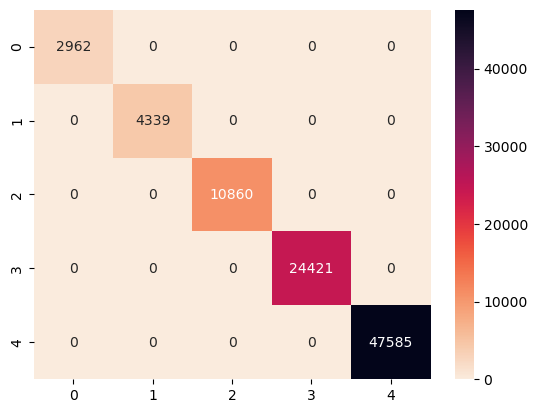

In [92]:
confusion_metrics = metrics.confusion_matrix (y_actual, y_pred_rating)
sns.heatmap(cm_df, annot=True, fmt = '.0f',cmap=sns.color_palette("rocket_r", as_cmap=True))

### Surprisingly, model's output is perfect (which mean something may be wrong). We will investigate this later

### Let's calculate RMSE now

In [89]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval()
y_pred = []
y_actual = []

with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        model_output = model(batched_data['users'].to(device), 
                       batched_data["books"].to(device))
        

        # Collect data for 
        model_output_list.append(model_output.sum().item() / len(batched_data['users']) )

        target_rating = batched_data["ratings"].to(device)
        
        target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))


# squared If True returns MSE value, if False returns RMSE value.
rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f"rms: {rms}")

rms: 0.46302609368793995


### Our main goal is to recommend books based on user's personality types. The steps we will follow to do that:
- Categorize books on different personality types using description and categories
- Do collaborative filtering to generate embeddings or latent factors to club similar books
- Ask user to enter a short bio that will be used to detect personality types. 


### Now we have a model that can predict the ratings. We need to do the following:

- Identify the personality of the user - We will do this by using hugging face library. The return value from the library is the probability of different personality types.
- Map the personality to book genre - We will have the mapping done 
- Identify book embedding for the personality/genre. For now, take the average of the embedding
- Or run a new regression to connect personality type and book embedding

In [213]:
a = input()

Hi, I am siddhant


In [214]:
print (a)

Hi, I am siddhant


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)